### 0. Import bibliotek, które mogą się przydać

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt, cm as mpl_cm
import seaborn as sns
from Bio import pairwise2
from Bio import Align
from Bio.Align import substitution_matrices
from matplotlib import ticker
from scipy.spatial.distance import pdist
from Bio.Align import substitution_matrices
from scipy.spatial.distance import squareform
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn import manifold, datasets

from sklearn.cluster import AgglomerativeClustering
import networkx as nx

c:\Users\marce\AppData\Local\Programs\Python\Python39\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


### 1. Wczytaj pobrane dane jako pandas dataframe

In [2]:
df = pd.read_csv("10k_PBMC_5pv2_nextgem_Chromium_Controller_10k_PBMC_5pv2_nextgem_Chromium_Controller_vdj_t_clonotypes.csv")

In [3]:
df

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence
0,clonotype1,27,0.005918,TRB:CASSFGNTIYF;TRA:CAYLLGTYKYIF,TRB:TGTGCCAGCAGTTTTGGAAACACCATATATTTT;TRA:TGTG...,NaN,NaN
1,clonotype2,12,0.002630,TRA:CAMERGYSTLTF,TRA:TGTGCAATGGAAAGAGGATACAGCACCCTCACCTTT,NaN,NaN
2,clonotype3,11,0.002411,TRB:CASSQNRRTGGINTEAFF;TRA:CGGDDMRF,TRB:TGTGCCAGCAGCCAGAATCGCCGGACAGGTGGGATCAACACT...,NaN,NaN
3,clonotype4,10,0.002192,TRB:CASSEPGASRNEQFF;TRA:CVVSGDSSYKLIF,TRB:TGTGCCAGCAGTGAACCTGGTGCCAGTCGGAATGAGCAGTTC...,NaN,NaN
4,clonotype5,7,0.001534,TRB:CASSIDVEGLSGYTF;TRA:CIPLGVRVKAAGNKLTF;TRA:...,TRB:TGTGCCAGTAGTATAGATGTGGAGGGCCTGAGTGGCTACACC...,NaN,NaN
...,...,...,...,...,...,...,...
4277,clonotype4278,1,0.000219,TRB:CASSGPGQGRSRGYTF;TRA:CAFMKHMNTGNQFYF,TRB:TGTGCCAGCAGCGGGCCGGGACAGGGCCGATCAAGGGGCTAC...,NaN,NaN
4278,clonotype4279,1,0.000219,TRB:CASSLEAGRFAGANVLTF,TRB:TGTGCCAGCAGCTTAGAGGCTGGACGTTTCGCTGGGGCCAAC...,NaN,NaN
4279,clonotype4280,1,0.000219,TRB:CASSLGYEGVYLVGEQYF;TRA:CAAVMDSSYKLIF,TRB:TGTGCCAGCAGCTTAGGCTATGAAGGGGTTTACTTGGTGGGC...,NaN,NaN
4280,clonotype4281,1,0.000219,TRB:CASSLGLGGGAFRNYEQYF;TRA:CALHGKLQF;TRA:CAVE...,TRB:TGTGCCAGCAGCTTAGGCCTGGGCGGGGGGGCCTTCCGAAAC...,NaN,NaN


### 2. Rozdziel dane w kolumnie cdr3s_aa, tak aby powstała kolumna dla tcra oraz tcrb 

In [4]:
def tcra_return(x, subunit):
    trs = x.split(';')
    if len(trs) > 1:
        if subunit == "TRA":
            if trs[-1][0:3] == "TRA":
                return trs[-1].lstrip('TRA:')
            else:
                return trs[0].lstrip('TRA:')
        else:
            if trs[0][0:3] == "TRB":
                return trs[0].lstrip('TRB:')
            else:
                return trs[1].lstrip('TRB:')
    else:
        if subunit == trs[0][0:3]:
            return trs[0][4:]
    

In [5]:
df['tcra_aa'] = df['cdr3s_aa'].apply(lambda x: tcra_return(x, subunit="TRA"))
df['tcrb_aa'] = df['cdr3s_aa'].apply(lambda x: tcra_return(x, subunit="TRB"))

In [6]:
df

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence,tcra_aa,tcrb_aa
0,clonotype1,27,0.005918,TRB:CASSFGNTIYF;TRA:CAYLLGTYKYIF,TRB:TGTGCCAGCAGTTTTGGAAACACCATATATTTT;TRA:TGTG...,NaN,NaN,CAYLLGTYKYIF,CASSFGNTIYF
1,clonotype2,12,0.002630,TRA:CAMERGYSTLTF,TRA:TGTGCAATGGAAAGAGGATACAGCACCCTCACCTTT,NaN,NaN,CAMERGYSTLTF,None
2,clonotype3,11,0.002411,TRB:CASSQNRRTGGINTEAFF;TRA:CGGDDMRF,TRB:TGTGCCAGCAGCCAGAATCGCCGGACAGGTGGGATCAACACT...,NaN,NaN,CGGDDMRF,CASSQNRRTGGINTEAFF
3,clonotype4,10,0.002192,TRB:CASSEPGASRNEQFF;TRA:CVVSGDSSYKLIF,TRB:TGTGCCAGCAGTGAACCTGGTGCCAGTCGGAATGAGCAGTTC...,NaN,NaN,CVVSGDSSYKLIF,CASSEPGASRNEQFF
4,clonotype5,7,0.001534,TRB:CASSIDVEGLSGYTF;TRA:CIPLGVRVKAAGNKLTF;TRA:...,TRB:TGTGCCAGTAGTATAGATGTGGAGGGCCTGAGTGGCTACACC...,NaN,NaN,CIVRVAYNFGNEKLTF,CASSIDVEGLSGYTF
...,...,...,...,...,...,...,...,...,...
4277,clonotype4278,1,0.000219,TRB:CASSGPGQGRSRGYTF;TRA:CAFMKHMNTGNQFYF,TRB:TGTGCCAGCAGCGGGCCGGGACAGGGCCGATCAAGGGGCTAC...,NaN,NaN,CAFMKHMNTGNQFYF,CASSGPGQGRSRGYTF
4278,clonotype4279,1,0.000219,TRB:CASSLEAGRFAGANVLTF,TRB:TGTGCCAGCAGCTTAGAGGCTGGACGTTTCGCTGGGGCCAAC...,NaN,NaN,None,CASSLEAGRFAGANVLTF
4279,clonotype4280,1,0.000219,TRB:CASSLGYEGVYLVGEQYF;TRA:CAAVMDSSYKLIF,TRB:TGTGCCAGCAGCTTAGGCTATGAAGGGGTTTACTTGGTGGGC...,NaN,NaN,CAAVMDSSYKLIF,CASSLGYEGVYLVGEQYF
4280,clonotype4281,1,0.000219,TRB:CASSLGLGGGAFRNYEQYF;TRA:CALHGKLQF;TRA:CAVE...,TRB:TGTGCCAGCAGCTTAGGCCTGGGCGGGGGGGCCTTCCGAAAC...,NaN,NaN,CAVEGDSWGKLQF,CASSLGLGGGAFRNYEQYF


W trakcie rozdzielania danych zauważono, że w niektóych komórkach znajdują się po 2 lub nawet 3 TCR(raczej TCRB). <br>
Dlatego moja wyżej zaimplementowana funkcja obchodzi ten fakt aby dane były spójne w rozdzielonych kolumnach. (ostatecznie jeden TCRB jest wzięty) <br>
Poniżej następuje sorawdzenie czy nie ma jakiś nieprawidłowości

In [7]:
#sprawdzenie czy nadal nie ma błędów
df2=df.dropna()
df2[df2['tcrb_aa'].str.contains('A:')]
df2[df2['tcra_aa'].str.contains('B:')]

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence,tcra_aa,tcrb_aa


### 3. Dokonaj wizualizacji rozkładu długości motywów zmiennych w podjednostkach alfa oraz beta

In [8]:
def tcr_len(x):
    if x:
        return len(x)
    else: return 0

In [9]:
df['tcra_aa_len'] = df['tcra_aa'].apply (lambda x: tcr_len(x))
df['tcrb_aa_len'] = df['tcrb_aa'].apply (lambda x: tcr_len(x))

In [10]:
df

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence,tcra_aa,tcrb_aa,tcra_aa_len,tcrb_aa_len
0,clonotype1,27,0.005918,TRB:CASSFGNTIYF;TRA:CAYLLGTYKYIF,TRB:TGTGCCAGCAGTTTTGGAAACACCATATATTTT;TRA:TGTG...,NaN,NaN,CAYLLGTYKYIF,CASSFGNTIYF,12,11
1,clonotype2,12,0.002630,TRA:CAMERGYSTLTF,TRA:TGTGCAATGGAAAGAGGATACAGCACCCTCACCTTT,NaN,NaN,CAMERGYSTLTF,None,12,0
2,clonotype3,11,0.002411,TRB:CASSQNRRTGGINTEAFF;TRA:CGGDDMRF,TRB:TGTGCCAGCAGCCAGAATCGCCGGACAGGTGGGATCAACACT...,NaN,NaN,CGGDDMRF,CASSQNRRTGGINTEAFF,8,18
3,clonotype4,10,0.002192,TRB:CASSEPGASRNEQFF;TRA:CVVSGDSSYKLIF,TRB:TGTGCCAGCAGTGAACCTGGTGCCAGTCGGAATGAGCAGTTC...,NaN,NaN,CVVSGDSSYKLIF,CASSEPGASRNEQFF,13,15
4,clonotype5,7,0.001534,TRB:CASSIDVEGLSGYTF;TRA:CIPLGVRVKAAGNKLTF;TRA:...,TRB:TGTGCCAGTAGTATAGATGTGGAGGGCCTGAGTGGCTACACC...,NaN,NaN,CIVRVAYNFGNEKLTF,CASSIDVEGLSGYTF,16,15
...,...,...,...,...,...,...,...,...,...,...,...
4277,clonotype4278,1,0.000219,TRB:CASSGPGQGRSRGYTF;TRA:CAFMKHMNTGNQFYF,TRB:TGTGCCAGCAGCGGGCCGGGACAGGGCCGATCAAGGGGCTAC...,NaN,NaN,CAFMKHMNTGNQFYF,CASSGPGQGRSRGYTF,15,16
4278,clonotype4279,1,0.000219,TRB:CASSLEAGRFAGANVLTF,TRB:TGTGCCAGCAGCTTAGAGGCTGGACGTTTCGCTGGGGCCAAC...,NaN,NaN,None,CASSLEAGRFAGANVLTF,0,18
4279,clonotype4280,1,0.000219,TRB:CASSLGYEGVYLVGEQYF;TRA:CAAVMDSSYKLIF,TRB:TGTGCCAGCAGCTTAGGCTATGAAGGGGTTTACTTGGTGGGC...,NaN,NaN,CAAVMDSSYKLIF,CASSLGYEGVYLVGEQYF,13,18
4280,clonotype4281,1,0.000219,TRB:CASSLGLGGGAFRNYEQYF;TRA:CALHGKLQF;TRA:CAVE...,TRB:TGTGCCAGCAGCTTAGGCCTGGGCGGGGGGGCCTTCCGAAAC...,NaN,NaN,CAVEGDSWGKLQF,CASSLGLGGGAFRNYEQYF,13,19


<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Wizualizacji możesz dokonać (histogram 2D) np. za pomocą biblioteki seaborn.


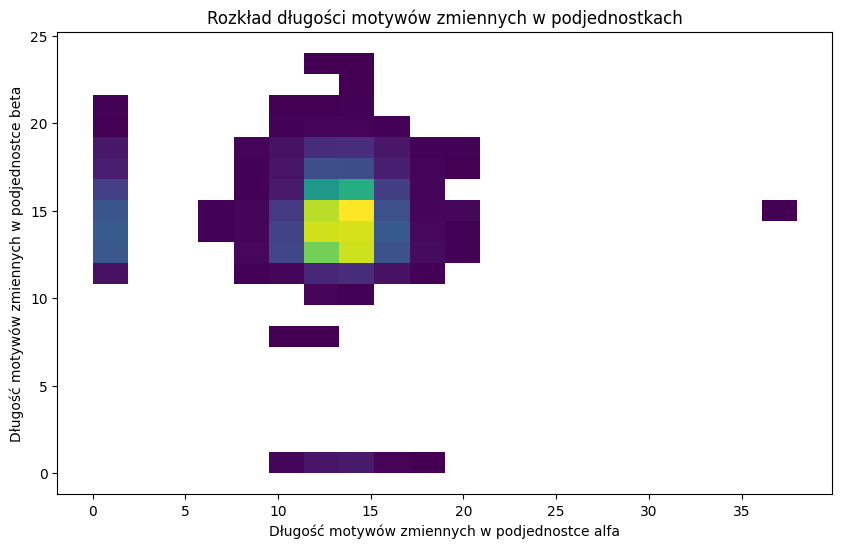

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(x='tcra_aa_len', y='tcrb_aa_len', data=df, bins=20, cmap='viridis')
plt.title('Rozkład długości motywów zmiennych w podjednostkach')
plt.xlabel('Długość motywów zmiennych w podjednostce alfa')
plt.ylabel('Długość motywów zmiennych w podjednostce beta')
plt.show()

### 4. Sprawdź jak często występują 2 wybrane aminokwasy w podjednostkach alfa i beta, zobrazuj wyniki

In [12]:
def tcr_amino_count(x, amino):
    if x:
        return x.count(amino)
    else:
        return 0

In [13]:
df['tcra_aa_amino_G'] = df['tcra_aa'].apply (lambda x: tcr_amino_count(x, amino='G'))
df['tcrb_aa_amino_G'] = df['tcrb_aa'].apply (lambda x: tcr_amino_count(x, amino='G'))

df['tcra_aa_amino_L'] = df['tcra_aa'].apply (lambda x: tcr_amino_count(x, amino='L'))
df['tcrb_aa_amino_L'] = df['tcrb_aa'].apply (lambda x: tcr_amino_count(x, amino='L'))

df['tcra_aa_amino_C'] = df['tcra_aa'].apply (lambda x: tcr_amino_count(x, amino='C'))
df['tcrb_aa_amino_C'] = df['tcrb_aa'].apply (lambda x: tcr_amino_count(x, amino='C'))

df['tcra_aa_amino_S'] = df['tcra_aa'].apply (lambda x: tcr_amino_count(x, amino='S'))
df['tcrb_aa_amino_S'] = df['tcrb_aa'].apply (lambda x: tcr_amino_count(x, amino='S'))

In [14]:
df

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence,tcra_aa,tcrb_aa,tcra_aa_len,tcrb_aa_len,tcra_aa_amino_G,tcrb_aa_amino_G,tcra_aa_amino_L,tcrb_aa_amino_L,tcra_aa_amino_C,tcrb_aa_amino_C,tcra_aa_amino_S,tcrb_aa_amino_S
0,clonotype1,27,0.005918,TRB:CASSFGNTIYF;TRA:CAYLLGTYKYIF,TRB:TGTGCCAGCAGTTTTGGAAACACCATATATTTT;TRA:TGTG...,NaN,NaN,CAYLLGTYKYIF,CASSFGNTIYF,12,11,1,1,2,0,1,1,0,2
1,clonotype2,12,0.002630,TRA:CAMERGYSTLTF,TRA:TGTGCAATGGAAAGAGGATACAGCACCCTCACCTTT,NaN,NaN,CAMERGYSTLTF,None,12,0,1,0,1,0,1,0,1,0
2,clonotype3,11,0.002411,TRB:CASSQNRRTGGINTEAFF;TRA:CGGDDMRF,TRB:TGTGCCAGCAGCCAGAATCGCCGGACAGGTGGGATCAACACT...,NaN,NaN,CGGDDMRF,CASSQNRRTGGINTEAFF,8,18,2,2,0,0,1,1,0,2
3,clonotype4,10,0.002192,TRB:CASSEPGASRNEQFF;TRA:CVVSGDSSYKLIF,TRB:TGTGCCAGCAGTGAACCTGGTGCCAGTCGGAATGAGCAGTTC...,NaN,NaN,CVVSGDSSYKLIF,CASSEPGASRNEQFF,13,15,1,1,1,0,1,1,3,3
4,clonotype5,7,0.001534,TRB:CASSIDVEGLSGYTF;TRA:CIPLGVRVKAAGNKLTF;TRA:...,TRB:TGTGCCAGTAGTATAGATGTGGAGGGCCTGAGTGGCTACACC...,NaN,NaN,CIVRVAYNFGNEKLTF,CASSIDVEGLSGYTF,16,15,1,2,1,1,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,clonotype4278,1,0.000219,TRB:CASSGPGQGRSRGYTF;TRA:CAFMKHMNTGNQFYF,TRB:TGTGCCAGCAGCGGGCCGGGACAGGGCCGATCAAGGGGCTAC...,NaN,NaN,CAFMKHMNTGNQFYF,CASSGPGQGRSRGYTF,15,16,1,4,0,0,1,1,0,3
4278,clonotype4279,1,0.000219,TRB:CASSLEAGRFAGANVLTF,TRB:TGTGCCAGCAGCTTAGAGGCTGGACGTTTCGCTGGGGCCAAC...,NaN,NaN,None,CASSLEAGRFAGANVLTF,0,18,0,2,0,2,0,1,0,2
4279,clonotype4280,1,0.000219,TRB:CASSLGYEGVYLVGEQYF;TRA:CAAVMDSSYKLIF,TRB:TGTGCCAGCAGCTTAGGCTATGAAGGGGTTTACTTGGTGGGC...,NaN,NaN,CAAVMDSSYKLIF,CASSLGYEGVYLVGEQYF,13,18,0,3,1,2,1,1,2,2
4280,clonotype4281,1,0.000219,TRB:CASSLGLGGGAFRNYEQYF;TRA:CALHGKLQF;TRA:CAVE...,TRB:TGTGCCAGCAGCTTAGGCCTGGGCGGGGGGGCCTTCCGAAAC...,NaN,NaN,CAVEGDSWGKLQF,CASSLGLGGGAFRNYEQYF,13,19,2,4,1,2,1,1,1,2


<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Wizualizacji możesz dokonać (histogram 2D) np. za pomocą biblioteki seaborn.



Text(0, 0.5, 'TRCB')

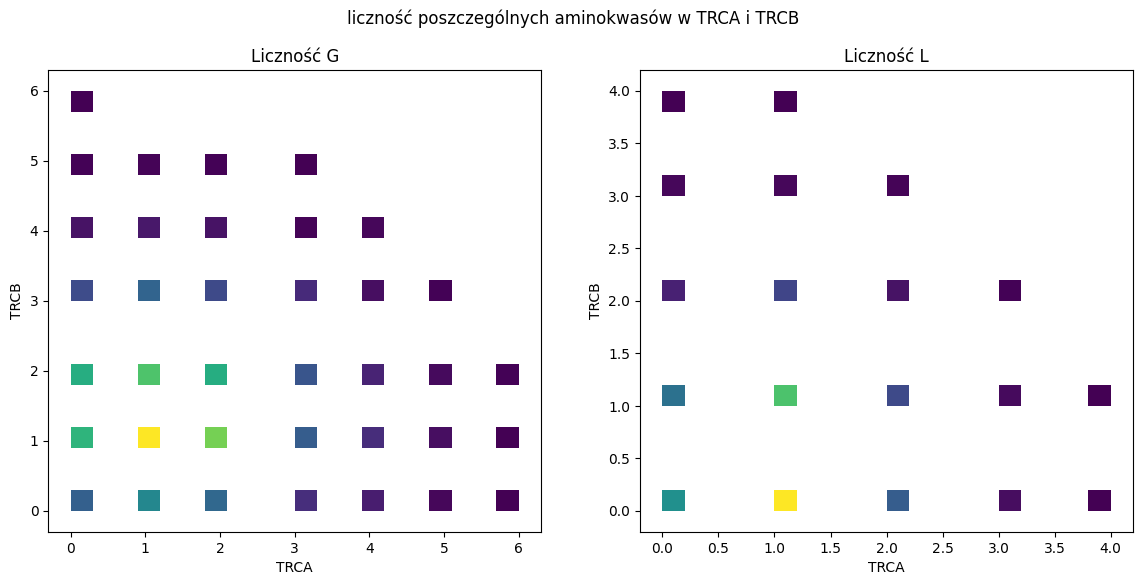

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(14)
fig.suptitle('liczność poszczególnych aminokwasów w TRCA i TRCB')

sns.histplot(x='tcra_aa_amino_G', y='tcrb_aa_amino_G', data=df, bins=20, cmap='viridis', ax=ax1)
ax1.set_title('Liczność G')
ax1.set_xlabel('TRCA')
ax1.set_ylabel('TRCB')

sns.histplot(x='tcra_aa_amino_L', y='tcrb_aa_amino_L', data=df, bins=20, cmap='viridis', ax=ax2)
ax2.set_title('Liczność L')
ax2.set_xlabel('TRCA')
ax2.set_ylabel('TRCB')

### 5. Zaproponuj sposób wyznacznia podobieństwa między parami sekwencji CDR3 

#### Usunięto najpierw wiersze w których brakowało TRCA lub TRCB i wybrano podbziór tabeli do dalszej anlizy

In [16]:
df = df.dropna(subset=['tcra_aa', 'tcrb_aa'])
df_2 = df.iloc[5:505,:]
df_2

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence,tcra_aa,tcrb_aa,tcra_aa_len,tcrb_aa_len,tcra_aa_amino_G,tcrb_aa_amino_G,tcra_aa_amino_L,tcrb_aa_amino_L,tcra_aa_amino_C,tcrb_aa_amino_C,tcra_aa_amino_S,tcrb_aa_amino_S
6,clonotype7,6,0.001315,TRB:CASSVGQGVPMEQFF;TRA:CALTSSSNDYKLSF,TRB:TGCGCCAGCAGCGTAGGACAGGGAGTCCCGATGGAGCAGTTC...,NaN,NaN,CALTSSSNDYKLSF,CASSVGQGVPMEQFF,14,15,0,2,2,0,1,1,4,2
7,clonotype8,5,0.001096,TRB:CASSSGQVTGELFF;TRA:CAPSDSNYQLIW,TRB:TGTGCCAGCAGTTCCGGACAGGTCACCGGGGAGCTGTTTTTT...,NaN,TRA:gene;TRB:gene,CAPSDSNYQLIW,CASSSGQVTGELFF,12,14,0,2,1,1,1,1,2,3
8,clonotype9,5,0.001096,TRB:CASSTGAGPNTGELFF;TRA:CAVRSSSNDYKLSF,TRB:TGTGCCAGCAGCACAGGGGCGGGACCGAACACCGGGGAGCTG...,NaN,TRA:gene,CAVRSSSNDYKLSF,CASSTGAGPNTGELFF,14,16,0,3,1,1,1,1,4,2
9,clonotype10,5,0.001096,TRB:CASSLEPGQRGSPLHF;TRA:CAGSGMNTGFQKLVF,TRB:TGTGCCAGCAGCTTGGAACCGGGACAGCGAGGATCACCCCTC...,NaN,NaN,CAGSGMNTGFQKLVF,CASSLEPGQRGSPLHF,15,16,3,2,1,2,1,1,1,3
10,clonotype11,5,0.001096,TRB:CASSLGGLAGRTDTQYF;TRA:CVVSGSARQLTF,TRB:TGTGCCAGCAGTTTAGGCGGGCTAGCGGGGAGAACAGATACG...,NaN,NaN,CVVSGSARQLTF,CASSLGGLAGRTDTQYF,12,17,1,3,1,2,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,clonotype582,1,0.000219,TRB:CSAPGPLGTDTQYF;TRA:CALSGRTGANNLFF,TRB:TGCAGTGCTCCCGGGCCTCTGGGCACAGATACGCAGTATTTT...,NaN,TRB:gene,CALSGRTGANNLFF,CSAPGPLGTDTQYF,14,14,2,2,2,1,1,1,1,1
582,clonotype583,1,0.000219,TRB:CASSIDPAAGGTDTQYF;TRB:CRIRSRDDNYGYTF;TRA:C...,TRB:TGTGCCAGTAGTATAGATCCGGCGGCGGGGGGCACAGATACG...,NaN,TRB:gene,CAYKGRSQGGSEKLVF,CASSIDPAAGGTDTQYF,16,17,3,2,1,0,1,1,2,2
583,clonotype584,1,0.000219,TRB:CSARDSRLDDTQYF;TRA:CVVSQNNARLMF,TRB:TGCAGTGCTAGAGATTCCAGACTAGACGATACGCAGTATTTT...,NaN,TRB:gene,CVVSQNNARLMF,CSARDSRLDDTQYF,12,14,0,0,1,1,1,1,1,2
584,clonotype585,1,0.000219,TRB:CSARGTGEFFEAFF;TRA:CALRADSGNTPLVF,TRB:TGCAGTGCTAGAGGGACAGGAGAATTCTTTGAAGCTTTCTTT...,NaN,TRB:gene,CALRADSGNTPLVF,CSARGTGEFFEAFF,14,14,1,2,2,0,1,1,1,1


In [17]:
def tcr_alig_2(x):
    dist_matrix = np.empty((len(x), len(x)))

    substitution_matrices.load()
    matrix = substitution_matrices.load("BLOSUM62")
    aligner = Align.PairwiseAligner()
    aligner.substitution_matrix = matrix

    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if x.iloc[i].tcra_aa and x.iloc[j].tcra_aa:
                alignments_trca = aligner.score(x.iloc[i].tcra_aa, x.iloc[j].tcra_aa)
            # else:
            #     alignments_trca = 0.0
            if x.iloc[i].tcrb_aa and x.iloc[j].tcrb_aa:
                alignments_trcb = aligner.score(x.iloc[i].tcrb_aa, x.iloc[j].tcrb_aa)
            # else:
            #     alignments_trcb = 0.0
            combined = (alignments_trca + alignments_trcb) / 2
            dist_matrix[i][j] = combined
    return dist_matrix

Powyższa metoda w oparciu o macierz BLOSUM62 liczy podobieństwo podjednostek alfa i beta między każdą parą tcr i ostatecznie liczy średnią z tych podobieństw.

### 6. W oparciu o zaproponowaną miarę stwórz macierz dystansu. 

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Jeśli obliczenia trają za długo, nie musisz korzystać z pełnego zbioru danych. Ogranicz zbiór danych wegle swoich potrzeb i możliwości. Pamiętaj jednak, że do dalszych analiz powinien zawierać on co najmniej kilkaset receptorów. 
</div>

In [18]:
distance_matrix_2 = tcr_alig_2(df_2)

In [19]:
distance_matrix_2 = np.triu(distance_matrix_2, 1).T + np.triu(distance_matrix_2)
distance_matrix_2

array([[ 0. , 47.5, 60.5, ..., 34.5, 41.5, 40.5],
       [47.5,  0. , 50. , ..., 31.5, 43. , 37.5],
       [60.5, 50. ,  0. , ..., 35. , 45.5, 40.5],
       ...,
       [34.5, 31.5, 35. , ...,  0. , 34.5, 38. ],
       [41.5, 43. , 45.5, ..., 34.5,  0. , 42.5],
       [40.5, 37.5, 40.5, ..., 38. , 42.5,  0. ]])

In [20]:
dd = pd.DataFrame(distance_matrix_2)
dd.describe()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,...,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,41.979000,38.537000,43.182000,42.728000,41.477000,42.304000,38.530000,38.211000,39.482000,40.12900,...,40.848000,41.064000,39.866000,42.96000,38.566000,41.563000,44.936000,36.750000,40.491000,39.620000
std,4.852334,5.375493,4.871276,5.148109,5.246047,4.866101,4.330428,4.820524,6.101075,4.98634,...,4.980915,5.327351,4.938504,5.27656,4.989733,4.984699,5.339656,4.361599,4.452198,4.953451
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,35.000000,40.500000,39.500000,38.000000,39.500000,36.000000,35.000000,36.000000,37.00000,...,37.500000,37.500000,36.875000,39.50000,35.500000,38.500000,41.500000,33.500000,37.500000,37.000000
50%,42.000000,38.000000,43.000000,42.500000,41.000000,42.000000,38.250000,38.000000,38.500000,40.00000,...,40.500000,40.500000,39.750000,43.00000,38.500000,41.000000,44.500000,36.500000,40.500000,39.000000
75%,45.000000,41.500000,46.000000,45.500000,44.500000,45.000000,41.500000,40.500000,42.000000,43.00000,...,44.000000,44.000000,43.000000,46.50000,41.500000,44.000000,48.000000,39.500000,43.500000,42.500000
max,60.500000,55.500000,60.500000,58.500000,59.000000,59.000000,52.000000,57.500000,62.500000,60.00000,...,62.000000,59.000000,59.000000,61.00000,53.500000,59.000000,63.500000,50.500000,52.000000,57.500000


In [21]:
dd.to_csv('dm.csv')

In [22]:
distance_matrix = pd.read_csv('./dm.csv', index_col=0)
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,47.5,60.5,47.5,42.0,43.5,46.0,39.5,42.0,43.0,...,46.5,41.5,40.0,45.5,39.5,42.5,45.0,34.5,41.5,40.5
1,47.5,0.0,50.0,43.5,36.5,36.5,40.5,34.0,51.0,40.5,...,36.5,35.5,34.0,43.0,36.5,33.5,39.0,31.5,43.0,37.5
2,60.5,50.0,0.0,45.5,44.5,43.0,52.0,34.5,42.0,42.0,...,46.5,46.0,39.5,40.0,42.5,42.5,46.5,35.0,45.5,40.5
3,47.5,43.5,45.5,0.0,42.0,43.5,38.0,46.5,39.5,48.5,...,38.5,41.0,42.5,47.5,50.5,46.0,54.5,34.0,40.5,45.5
4,42.0,36.5,44.5,42.0,0.0,48.0,37.5,36.5,42.5,39.0,...,50.0,54.0,49.5,53.0,42.0,50.0,52.5,46.5,36.5,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,42.5,33.5,42.5,46.0,50.0,59.0,38.0,39.5,42.0,46.0,...,42.5,40.0,44.5,50.0,41.0,0.0,54.5,43.5,43.5,42.5
496,45.0,39.0,46.5,54.5,52.5,49.0,41.5,43.0,45.5,46.0,...,47.0,42.5,47.0,51.5,41.0,54.5,0.0,43.0,42.5,45.0
497,34.5,31.5,35.0,34.0,46.5,42.5,30.0,34.5,41.0,33.0,...,34.0,38.5,44.0,40.0,35.5,43.5,43.0,0.0,34.5,38.0
498,41.5,43.0,45.5,40.5,36.5,45.0,44.0,40.0,44.5,32.5,...,45.5,37.5,39.5,38.0,39.0,43.5,42.5,34.5,0.0,42.5


<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Możesz łatwo zwizualizować macierz za pomocą funkcji plt.imshow()
</div>


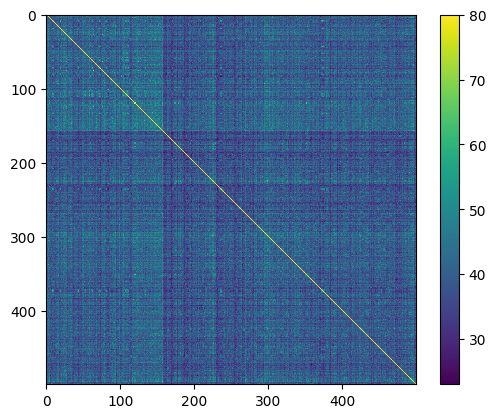

In [23]:
np.fill_diagonal(distance_matrix_2, 80)
c = plt.imshow(distance_matrix_2, interpolation='nearest')  
plt.colorbar(c)

### 7. Dokonaj grupowania repertuaru w oparciu o wybrany algorytm klasteryzacji. Wyniki zwizualizuj.

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Wygeneruj wynik klastrowania jako etykiety dla każdego receptora 
</div>

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> sns.clustermap może być tu pomocna, za jej pomocą pokarz wyniki grupowania (np. aglomeracyjnego). Postaraj się aby liczba wynikowych grup nie była za duża (i za mała). 
</div>

In [24]:
def avgDist(X, labels):
    D=pdist(X, metric='euclidean')
    dmatrix=squareform(D, checks=True)
    N=len(labels)
    L=list(set(labels))
    L.sort()
    result=0
    for i in L:
        Nc=sum(labels==i)
        S=0
        if Nc>1: S=np.sum(dmatrix[labels==i,:][:,labels==i])/(Nc*(Nc-1))
        result+=S*Nc/N
    return result

Text(0, 0.5, 'Average distance')

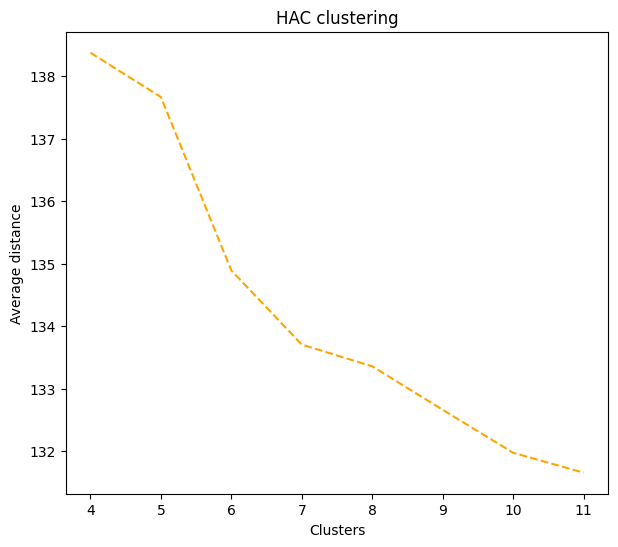

In [27]:
import warnings
from sklearn.cluster import AgglomerativeClustering
from scipy import spatial

warnings.filterwarnings('ignore')

distances_hac = []
#musimy to zrobić ponieważ nasza macierz jest symetryczna (inaczej otrzymujemy poniższe warningi), ALE ZA DUZO PAMIECI - NOT ENOUGH MEMORY TO ALLOCATE ???
# y = spatial.distance.squareform(distance_matrix)
# y = y.reshape(-1, 1)

for K in range(4,12):
    hac = AgglomerativeClustering(linkage="average", n_clusters=K).fit(distance_matrix)
    dist = avgDist(distance_matrix, hac.labels_)
    distances_hac.append(dist)

plt.figure(figsize=(7,6))
plt.plot([4,5,6,7,8,9,10,11], distances_hac, '--', color = 'orange')
plt.xticks([4,5,6,7,8,9,10,11])
plt.xlabel('Clusters')
plt.title('HAC clustering')
plt.ylabel('Average distance')

Z pomocą metody Elbow wybrano 7 klastrów

***w pozniejszym etapie okazało się, że 5 to wystarczająco, z resztą widać na wykresie, że róznice te są niewielkie

In [28]:
#hac = AgglomerativeClustering(linkage="average", n_clusters=7).fit(distance_matrix)
hac = AgglomerativeClustering(linkage="average", n_clusters=5).fit(distance_matrix)

In [29]:
warnings.filterwarnings('ignore')
df_2['cluster'] = hac.labels_
df_2['cluster'] = df_2['cluster'].astype(str) 
df_2

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence,tcra_aa,tcrb_aa,tcra_aa_len,tcrb_aa_len,tcra_aa_amino_G,tcrb_aa_amino_G,tcra_aa_amino_L,tcrb_aa_amino_L,tcra_aa_amino_C,tcrb_aa_amino_C,tcra_aa_amino_S,tcrb_aa_amino_S,cluster
6,clonotype7,6,0.001315,TRB:CASSVGQGVPMEQFF;TRA:CALTSSSNDYKLSF,TRB:TGCGCCAGCAGCGTAGGACAGGGAGTCCCGATGGAGCAGTTC...,NaN,NaN,CALTSSSNDYKLSF,CASSVGQGVPMEQFF,14,15,0,2,2,0,1,1,4,2,2
7,clonotype8,5,0.001096,TRB:CASSSGQVTGELFF;TRA:CAPSDSNYQLIW,TRB:TGTGCCAGCAGTTCCGGACAGGTCACCGGGGAGCTGTTTTTT...,NaN,TRA:gene;TRB:gene,CAPSDSNYQLIW,CASSSGQVTGELFF,12,14,0,2,1,1,1,1,2,3,2
8,clonotype9,5,0.001096,TRB:CASSTGAGPNTGELFF;TRA:CAVRSSSNDYKLSF,TRB:TGTGCCAGCAGCACAGGGGCGGGACCGAACACCGGGGAGCTG...,NaN,TRA:gene,CAVRSSSNDYKLSF,CASSTGAGPNTGELFF,14,16,0,3,1,1,1,1,4,2,1
9,clonotype10,5,0.001096,TRB:CASSLEPGQRGSPLHF;TRA:CAGSGMNTGFQKLVF,TRB:TGTGCCAGCAGCTTGGAACCGGGACAGCGAGGATCACCCCTC...,NaN,NaN,CAGSGMNTGFQKLVF,CASSLEPGQRGSPLHF,15,16,3,2,1,2,1,1,1,3,0
10,clonotype11,5,0.001096,TRB:CASSLGGLAGRTDTQYF;TRA:CVVSGSARQLTF,TRB:TGTGCCAGCAGTTTAGGCGGGCTAGCGGGGAGAACAGATACG...,NaN,NaN,CVVSGSARQLTF,CASSLGGLAGRTDTQYF,12,17,1,3,1,2,1,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,clonotype582,1,0.000219,TRB:CSAPGPLGTDTQYF;TRA:CALSGRTGANNLFF,TRB:TGCAGTGCTCCCGGGCCTCTGGGCACAGATACGCAGTATTTT...,NaN,TRB:gene,CALSGRTGANNLFF,CSAPGPLGTDTQYF,14,14,2,2,2,1,1,1,1,1,1
582,clonotype583,1,0.000219,TRB:CASSIDPAAGGTDTQYF;TRB:CRIRSRDDNYGYTF;TRA:C...,TRB:TGTGCCAGTAGTATAGATCCGGCGGCGGGGGGCACAGATACG...,NaN,TRB:gene,CAYKGRSQGGSEKLVF,CASSIDPAAGGTDTQYF,16,17,3,2,1,0,1,1,2,2,1
583,clonotype584,1,0.000219,TRB:CSARDSRLDDTQYF;TRA:CVVSQNNARLMF,TRB:TGCAGTGCTAGAGATTCCAGACTAGACGATACGCAGTATTTT...,NaN,TRB:gene,CVVSQNNARLMF,CSARDSRLDDTQYF,12,14,0,0,1,1,1,1,1,2,0
584,clonotype585,1,0.000219,TRB:CSARGTGEFFEAFF;TRA:CALRADSGNTPLVF,TRB:TGCAGTGCTAGAGGGACAGGAGAATTCTTTGAAGCTTTCTTT...,NaN,TRB:gene,CALRADSGNTPLVF,CSARGTGEFFEAFF,14,14,1,2,2,0,1,1,1,1,0


{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [40.0, 40.0, 62.5, 62.5],
  [12.5, 12.5, 51.25, 51.25],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [115.0, 115.0, 125.0, 125.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [120.0, 120.0, 142.5, 142.5],
  [92.5, 92.5, 131.25, 131.25],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [172.5, 172.5, 202.5, 202.5],
  [111.875, 111.875, 187.5, 187.5],
  [31.875, 31.875, 149.6875, 149.6875],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [245.0, 245.0, 262.5, 262.5],
  [235.0, 235.0, 253.75, 253.75],
  [225.0, 225.0, 244.375, 244.375],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [285.0, 285.0, 302.5, 302.5],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 340.0, 340.0],
  [355.0, 35

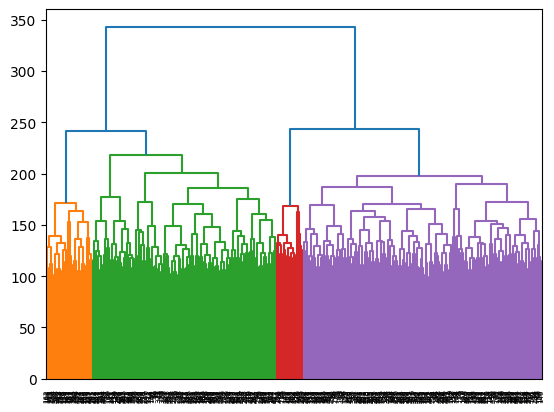

In [30]:
from scipy import cluster
Z = cluster.hierarchy.linkage(distance_matrix, "complete")
cluster.hierarchy.dendrogram(Z)

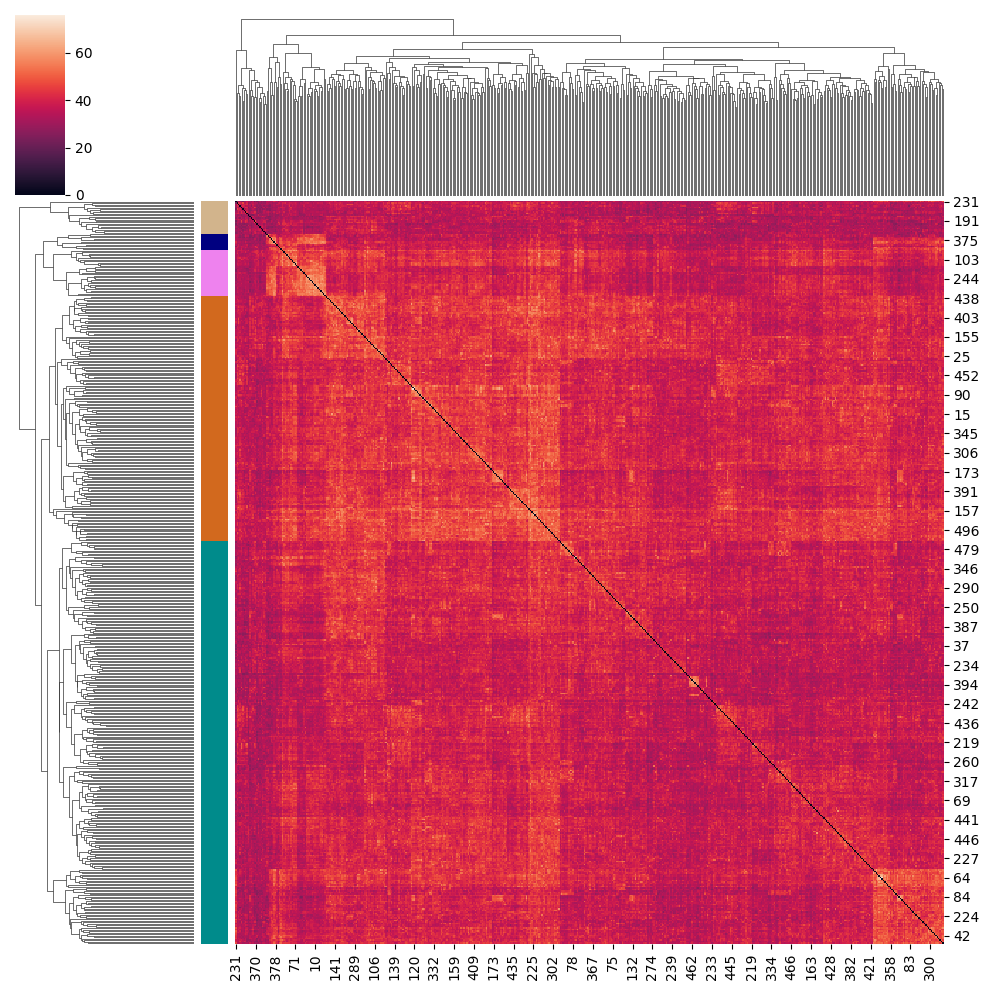

In [31]:
color_list = ['darkcyan', 'chocolate', 'violet', 'tan', 'navy', 'brown', 'palegreen']
dict_color = dict(zip(list(set(hac.labels_)), color_list))
row_colors = np.vectorize(dict_color.get)(hac.labels_)
sns.clustermap(distance_matrix, row_colors=row_colors)

### 8. Opracuj wektor numeryczny, który odzwierciedla Twoim zdaniem dostatecznie dobrze właściwości receptora. 

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Wykorzystaj do tego celu odległość od samodzielnie dobranych sekwencji referencyjnych (prototypowych). 
</div>



<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Wygeneruj najlepiej nowy dataframe z samymi numerycznymi danymi opisującymi każdy receptor 
</div>

In [32]:
ref_1a = df.iloc[0].tcra_aa
ref_1b = df.iloc[0].tcrb_aa

ref_2a = df.iloc[1].tcra_aa
ref_2b = df.iloc[1].tcrb_aa

ref_3a = df.iloc[2].tcra_aa
ref_3b = df.iloc[2].tcrb_aa

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [33]:
df_2.reset_index(drop=True, inplace=True)

In [38]:
numeric_repres = []

for i in range(len(df_2)):
    tcr = []  #ref_1a_pairwise ref_1b_pairwise ref_2a_pairwise ref_2bpairwise ref_1a_jaccard ref_1b_jaccard ref_2a_jaccard ref_2b_jaccard length_a length_b G_a G_b S_a S_b
    tcra = df_2.loc[i, "tcra_aa"]
    tcrb = df_2.loc[i, "tcrb_aa"]
    tcr.append(pairwise2.align.localxx(ref_1a, tcra, one_alignment_only=True, score_only=True))
    tcr.append(pairwise2.align.localxx(ref_1b, tcrb, one_alignment_only=True, score_only=True))
    tcr.append(pairwise2.align.localxx(ref_2a, tcra, one_alignment_only=True, score_only=True))
    tcr.append(pairwise2.align.localxx(ref_2b, tcrb, one_alignment_only=True, score_only=True))
    tcr.append(pairwise2.align.localxx(ref_3a, tcra, one_alignment_only=True, score_only=True))
    tcr.append(pairwise2.align.localxx(ref_3b, tcrb, one_alignment_only=True, score_only=True))
    tcr.append(jaccard(ref_1a, tcra)*20)
    tcr.append(jaccard(ref_1b, tcrb)*20)
    tcr.append(jaccard(ref_2a, tcra)*20)
    tcr.append(jaccard(ref_2b, tcrb)*20)
    tcr.append(jaccard(ref_3a, tcra)*20)
    tcr.append(jaccard(ref_3b, tcrb)*20)
    tcr.append(df_2.loc[i, "tcra_aa_len"])
    tcr.append(df_2.loc[i, "tcrb_aa_len"])
    tcr.append(df_2.loc[i, "tcra_aa_amino_G"]*4)
    tcr.append(df_2.loc[i, "tcrb_aa_amino_G"]*4)
    tcr.append(df_2.loc[i, "tcra_aa_amino_S"]*4)
    tcr.append(df_2.loc[i, "tcrb_aa_amino_S"]*4)
    numeric_repres.append(tcr)

In [39]:
cols = ['ref_1a_pairwise', 'ref_1b_pairwise', 'ref_2a_pairwise', 'ref_2bpairwise', 'ref_3a_pairwise', 'ref_3bpairwise', 'ref_1a_jaccard', 'ref_1b_jaccard', 
'ref_2a_jaccard', 'ref_2b_jaccard', 'ref_3a_jaccard', 'ref_3b_jaccard', 'length_a', 'length_b', 'G_a', 'G_b', 'S_a', 'S_b']
df_numeric = pd.DataFrame(numeric_repres, columns=cols)
df_numeric

,ref_1a_pairwise,ref_1b_pairwise,ref_2a_pairwise,ref_2bpairwise,ref_3a_pairwise,ref_3bpairwise,ref_1a_jaccard,ref_1b_jaccard,ref_2a_jaccard,ref_2b_jaccard,ref_3a_jaccard,ref_3b_jaccard,length_a,length_b,G_a,G_b,S_a,S_b
0,7.0,6.0,3.0,9.0,8.0,9.0,7.368421,4.761905,3.157895,5.384615,7.000000,7.272727,14,15,0,8,16,8
1,5.0,7.0,2.0,10.0,7.0,8.0,5.263158,6.315789,2.222222,6.666667,6.315789,6.363636,12,14,0,8,8,12
2,5.0,8.0,3.0,12.0,9.0,10.0,6.000000,7.000000,4.444444,6.153846,8.421053,6.956522,14,16,0,12,16,8
3,6.0,6.0,5.0,8.0,6.0,9.0,7.000000,4.545455,4.210526,6.153846,6.666667,8.181818,15,16,12,8,4,12
4,5.0,8.0,4.0,8.0,8.0,9.0,6.666667,6.666667,5.000000,5.925926,6.315789,5.600000,12,17,4,12,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,6.0,6.0,4.0,6.0,5.0,6.0,6.000000,7.777778,4.444444,5.600000,4.545455,6.363636,14,14,8,8,4,4
496,6.0,8.0,4.0,8.0,7.0,8.0,6.666667,8.000000,4.000000,5.925926,7.619048,5.600000,16,17,12,8,8,8
497,4.0,6.0,3.0,6.0,6.0,7.0,4.000000,6.315789,5.000000,5.600000,5.000000,5.217391,12,14,0,0,4,8
498,6.0,5.0,3.0,9.0,5.0,7.0,6.000000,6.315789,5.882353,6.666667,7.000000,6.363636,14,14,4,8,4,4


In [40]:
from scipy import stats
df_numeric_stand = stats.zscore(df_numeric)

In [41]:
from sklearn import preprocessing

x = df_numeric.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_numeric_norm = pd.DataFrame(x_scaled)

Stworzono 3 reprezentacje - surowe dane liczbowe, znormalizowane i standaryzowane. W kolejnych etapach porównywano różne reprezentacje.

### 9. Dokonaj projekcji wektorowej reprezentacji repertuaru na 2 wymiarową przestrzeń 

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Spróbuj metody t-sne. Zobacz też inne metody na stronie: https://scikit-learn.org/stable/modules/manifold.html
</div>

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Wynik możesz pokolorować np. zgodnie z wybraną jedną zmienną numeryczną użytą w wektorze.
</div>

** pokolorowano każdorazowo na podstawie przypisania do klastra wygenerowanego z macierzy dystansu

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30)
X_tsne = tsne.fit_transform(df_numeric)
tsne.kl_divergence_

1.0514857769012451

In [43]:
import plotly.express as px
fig = px.scatter(df_2, x=X_tsne[:, 0], y=X_tsne[:, 1], color="cluster")
fig.update_layout(
    title="t-SNE visualization of Numeric representation of TCRs",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
    width=800,  
    height=700,
)
fig.show()

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_numeric)
fig = px.scatter(df_2, x=X_pca[:, 0], y=X_pca[:, 1], color="cluster")
fig.update_layout(
    title="PCA visualization of Numeric representation of TCRs",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
    width=800,  
    height=700,
)
fig.show()

In [45]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df_numeric)

import plotly.express as px
fig = px.scatter(df_2, x=X_transformed[:, 0], y=X_transformed[:, 1], color="cluster")
fig.update_layout(
    title="MDS visualization of Numeric representation of TCRs",
    xaxis_title="First component",
    yaxis_title="Second component",
    width=800,  
    height=700,
)
fig.show()


We wszystkich 3 podejściach lepiej wypadało zastosowanie nieznormalizowanej/standaryzowanej tabeli danych.
Nie można stwierdzić dużych róznic między receptorami na podsatwie przypasowania do danego klastra, jednak widać że klastry są częśiowo izolowane/spójne.
Np. we wszystkich 3 metodach widać pewien wzorzec jeśli chodzi o receptory klastra fioletowego i niebieskiego.
W klastrach zielonym i czerwonym mamy najwięcej receptorow i są one dość wymieszane, ale można dostrzec pewne skupiska dla danego koloru.
Klaster pomaranczowy jest najmniej charakterystyczny, chociaż widać, że zawsze znajduje się tylko na jednej połowie wykresu - nie jest po nim rozrzucony. 

### 10. Stwórz macierz dystansu dla wektorowej reprezentacji repertuaru

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Spróbuj funkcji pdist.
</div>

In [46]:
distance_matrix_3 = pdist(df_numeric.values)
distance_matrix_3 = (squareform(distance_matrix_3))
distance_matrix_3

array([[ 0.        , 10.23036752,  6.87371436, ..., 16.26114899,
        14.35896612, 14.43426534],
       [10.23036752,  0.        , 11.35763984, ..., 11.4234222 ,
        11.2431151 , 10.05804602],
       [ 6.87371436, 11.35763984,  0.        , ..., 19.36005443,
        15.65789301, 16.96397048],
       ...,
       [16.26114899, 11.4234222 , 19.36005443, ...,  0.        ,
        11.2352215 ,  8.69287685],
       [14.35896612, 11.2431151 , 15.65789301, ..., 11.2352215 ,
         0.        ,  7.41790379],
       [14.43426534, 10.05804602, 16.96397048, ...,  8.69287685,
         7.41790379,  0.        ]])

### 11. Dokonaj grupowania wektorowej reprezentacji repertuaru w oparciu o macierz stworzoną w poprzednim kroku. Wyniki zaprezentuj na wykresie.

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Użyj tych samych metod co wcześniej. Wygeneruj wynik klastrowania jako etykiety dla każdego receptora. W podobny jak wcześniej sposób zwizualizuj wyniki.
</div>



Text(0, 0.5, 'Average distance')

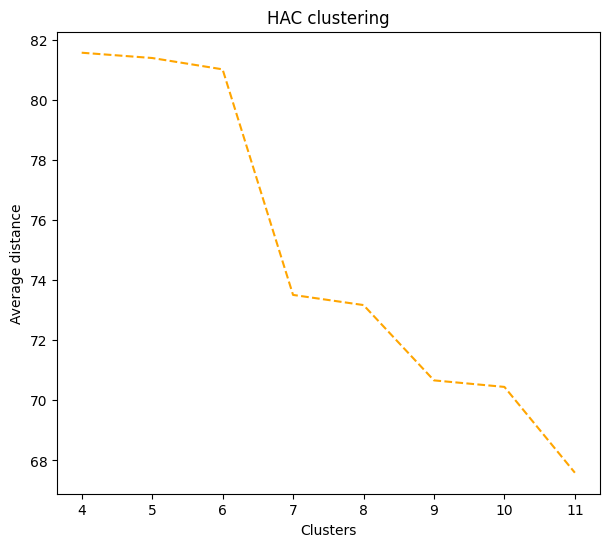

In [47]:
import warnings
# Disable all warnings in this cell
warnings.filterwarnings('ignore')

distances_hac = []
for K in range(4,12):
    hac = AgglomerativeClustering(linkage="average", n_clusters=K).fit(distance_matrix_3)
    dist = avgDist(distance_matrix_3, hac.labels_)
    distances_hac.append(dist)

plt.figure(figsize=(7,6))
plt.plot([4,5,6,7,8,9,10,11], distances_hac, '--', color = 'orange')
plt.xticks([4,5,6,7,8,9,10,11])
plt.xlabel('Clusters')
plt.title('HAC clustering')
plt.ylabel('Average distance')

In [48]:
warnings.filterwarnings('ignore')
hac = AgglomerativeClustering(linkage="average", n_clusters=7).fit(distance_matrix_3)

df_2['cluster'] = hac.labels_
df_2['cluster'] = df_2['cluster'].astype(str) 
df_2

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence,tcra_aa,tcrb_aa,tcra_aa_len,tcrb_aa_len,tcra_aa_amino_G,tcrb_aa_amino_G,tcra_aa_amino_L,tcrb_aa_amino_L,tcra_aa_amino_C,tcrb_aa_amino_C,tcra_aa_amino_S,tcrb_aa_amino_S,cluster
0,clonotype7,6,0.001315,TRB:CASSVGQGVPMEQFF;TRA:CALTSSSNDYKLSF,TRB:TGCGCCAGCAGCGTAGGACAGGGAGTCCCGATGGAGCAGTTC...,NaN,NaN,CALTSSSNDYKLSF,CASSVGQGVPMEQFF,14,15,0,2,2,0,1,1,4,2,4
1,clonotype8,5,0.001096,TRB:CASSSGQVTGELFF;TRA:CAPSDSNYQLIW,TRB:TGTGCCAGCAGTTCCGGACAGGTCACCGGGGAGCTGTTTTTT...,NaN,TRA:gene;TRB:gene,CAPSDSNYQLIW,CASSSGQVTGELFF,12,14,0,2,1,1,1,1,2,3,1
2,clonotype9,5,0.001096,TRB:CASSTGAGPNTGELFF;TRA:CAVRSSSNDYKLSF,TRB:TGTGCCAGCAGCACAGGGGCGGGACCGAACACCGGGGAGCTG...,NaN,TRA:gene,CAVRSSSNDYKLSF,CASSTGAGPNTGELFF,14,16,0,3,1,1,1,1,4,2,4
3,clonotype10,5,0.001096,TRB:CASSLEPGQRGSPLHF;TRA:CAGSGMNTGFQKLVF,TRB:TGTGCCAGCAGCTTGGAACCGGGACAGCGAGGATCACCCCTC...,NaN,NaN,CAGSGMNTGFQKLVF,CASSLEPGQRGSPLHF,15,16,3,2,1,2,1,1,1,3,3
4,clonotype11,5,0.001096,TRB:CASSLGGLAGRTDTQYF;TRA:CVVSGSARQLTF,TRB:TGTGCCAGCAGTTTAGGCGGGCTAGCGGGGAGAACAGATACG...,NaN,NaN,CVVSGSARQLTF,CASSLGGLAGRTDTQYF,12,17,1,3,1,2,1,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,clonotype582,1,0.000219,TRB:CSAPGPLGTDTQYF;TRA:CALSGRTGANNLFF,TRB:TGCAGTGCTCCCGGGCCTCTGGGCACAGATACGCAGTATTTT...,NaN,TRB:gene,CALSGRTGANNLFF,CSAPGPLGTDTQYF,14,14,2,2,2,1,1,1,1,1,2
496,clonotype583,1,0.000219,TRB:CASSIDPAAGGTDTQYF;TRB:CRIRSRDDNYGYTF;TRA:C...,TRB:TGTGCCAGTAGTATAGATCCGGCGGCGGGGGGCACAGATACG...,NaN,TRB:gene,CAYKGRSQGGSEKLVF,CASSIDPAAGGTDTQYF,16,17,3,2,1,0,1,1,2,2,2
497,clonotype584,1,0.000219,TRB:CSARDSRLDDTQYF;TRA:CVVSQNNARLMF,TRB:TGCAGTGCTAGAGATTCCAGACTAGACGATACGCAGTATTTT...,NaN,TRB:gene,CVVSQNNARLMF,CSARDSRLDDTQYF,12,14,0,0,1,1,1,1,1,2,1
498,clonotype585,1,0.000219,TRB:CSARGTGEFFEAFF;TRA:CALRADSGNTPLVF,TRB:TGCAGTGCTAGAGGGACAGGAGAATTCTTTGAAGCTTTCTTT...,NaN,TRB:gene,CALRADSGNTPLVF,CSARGTGEFFEAFF,14,14,1,2,2,0,1,1,1,1,2


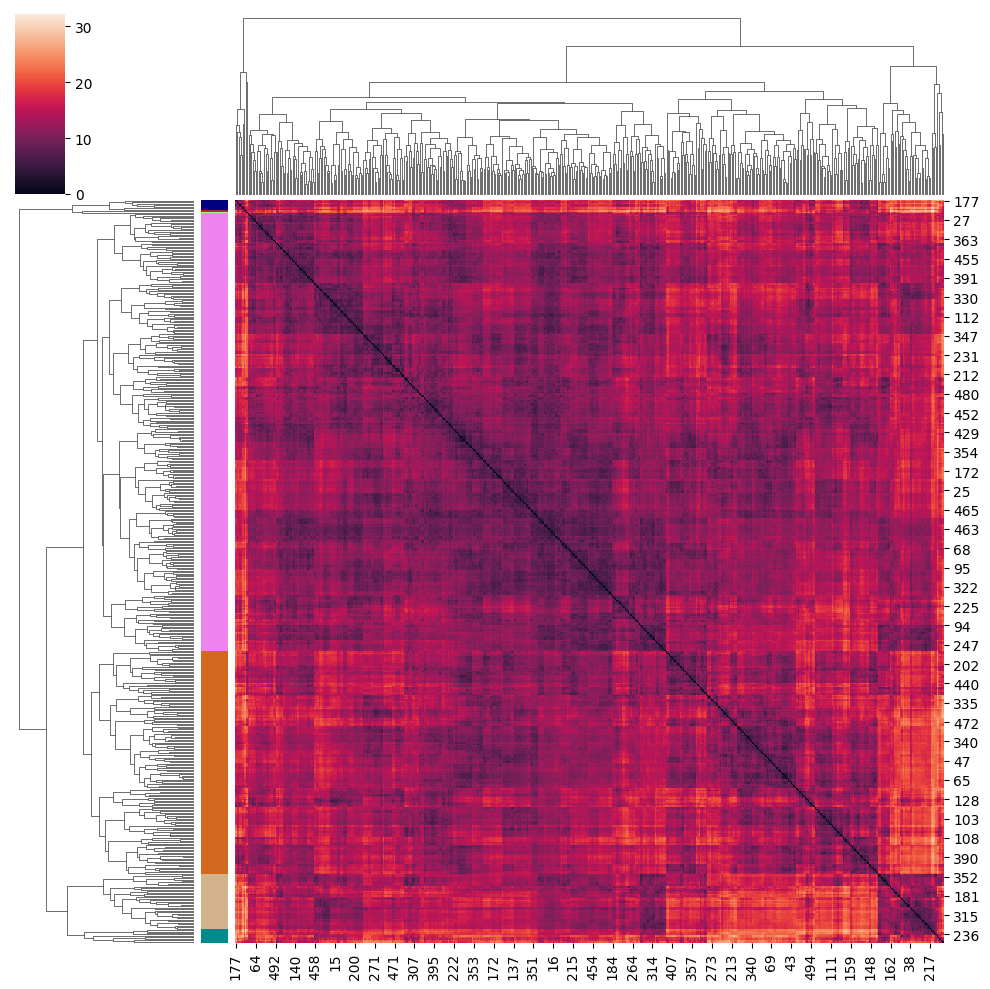

In [49]:
color_list = ['darkcyan', 'chocolate', 'violet', 'tan', 'navy', 'brown', 'palegreen', 'yellow', 'green']
dict_color = dict(zip(list(set(hac.labels_)), color_list))
row_colors = np.vectorize(dict_color.get)(hac.labels_)
sns.clustermap(distance_matrix_3, row_colors=row_colors)

### 12. Oznacz na projekcji repertuaru wygenerowane grupy (klastry) przy użyciu różnych kolorów

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Podmień w wykresie dla projekcji 2D barwy na takie, które odpowiadają etykietom klastrów.
</div>


In [50]:
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30)
X_tsne = tsne.fit_transform(df_numeric)
tsne.kl_divergence_

fig = px.scatter(df_2, x=X_tsne[:, 0], y=X_tsne[:, 1], color="cluster")
fig.update_layout(
    title="t-SNE visualization of Numeric representation of TCRs",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
    width=800,  
    height=700,
)
fig.show()

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_numeric)
fig = px.scatter(df_2, x=X_pca[:, 0], y=X_pca[:, 1], color="cluster")
fig.update_layout(
    title="PCA visualization of Numeric representation of TCRs",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
    width=800,  
    height=700,
)
fig.show()

In [52]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df_numeric)

import plotly.express as px
fig = px.scatter(df_2, x=X_transformed[:, 0], y=X_transformed[:, 1], color="cluster")
fig.update_layout(
    title="MDS visualization of Numeric representation of TCRs",
    xaxis_title="First component",
    yaxis_title="Second component",
    width=800,  
    height=700,
)
fig.show()

Porównując te 3 wykresy wygenerowane w oparciu o klastrowanie macierzy dystansy stworzonej na podstawie reprezentacji wektorowej (numerycznej), do wcześniejszych 3 wykresów, widać ze tutaj wyniki są zdecydowanie lepsze.
Wyróżniają się mocno 3 klastry, reszta jest bardzo słabo reprezentowalna.

### 13. Stwórz graf podobieństwa dla reperuatu w oparciu o macierz dystansu wygenerowaną na podstawie odległości pomiędzy sekwencjami receptorów.

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Aby zlokalizować w macierzy dystansu odpowiednie pary receptorów dla których ma powstać krawiędź możesz użyć funkcji numpy.where() 
</div>


In [204]:
edges = np.where(distance_matrix_2>61)
print(len(edges[0]))
print(edges)

602
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   8,   9,  10,  10,
        11,  12,  13,  14,  15,  15,  16,  16,  17,  17,  18,  19,  19,
        19,  20,  20,  21,  22,  23,  24,  25,  25,  26,  27,  27,  27,
        27,  28,  29,  30,  31,  32,  33,  33,  34,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  44,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  58,  59,  60,
        61,  62,  62,  63,  63,  64,  64,  64,  64,  65,  66,  67,  67,
        68,  69,  70,  71,  72,  72,  73,  74,  74,  75,  76,  76,  76,
        76,  77,  78,  79,  79,  80,  81,  82,  83,  84,  84,  85,  86,
        86,  87,  88,  89,  90,  91,  91,  92,  92,  93,  93,  94,  94,
        95,  96,  97,  98,  99,  99, 100, 101, 102, 102, 103, 104, 104,
       105, 106, 107, 107, 108, 108, 109, 109, 109, 110, 110, 110, 110,
       111, 111, 112, 113, 114, 115, 116, 117, 117, 118, 118, 119, 119,
       119, 119, 120, 120, 120, 121, 122, 123, 124, 124, 12

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Dla znalezionych par możesz utworzyć dataframe, który łatwo wczytać jako graf za pomocą biblioteki networkx (upewnij się, że masz najnowszą jej wersję).
</div>


In [205]:
pairs_df = pd.DataFrame(columns=['a', 'b', 'weight'])
for i in range(len(edges[0])):
    a = edges[0][i]
    b = edges[1][i]
    if a!=b:
        pairs_df.loc[i] = [a, b, distance_matrix_2[a, b]]
pairs_df[['a', 'b']] = pairs_df[['a', 'b']].astype(int)
pairs_df

,a,b,weight
9,8,373,62.5
12,10,19,62.5
18,15,152,62.0
20,16,353,62.5
22,17,119,62.5
...,...,...,...
487,390,376,66.0
560,462,86,63.5
589,490,222,62.0
596,496,144,61.5


<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Dokonaj wizualizacji stworzonego przez siebie grafu, pos = nx.spring_layout(G) może być przydatne do wyznaczenia współrzędnych węzłów
</div>

Powyżej wybrano 100 najbardziej podobnych do siebie TCR, a poniżej zwizalizowano je za pomocą kilku grafów:

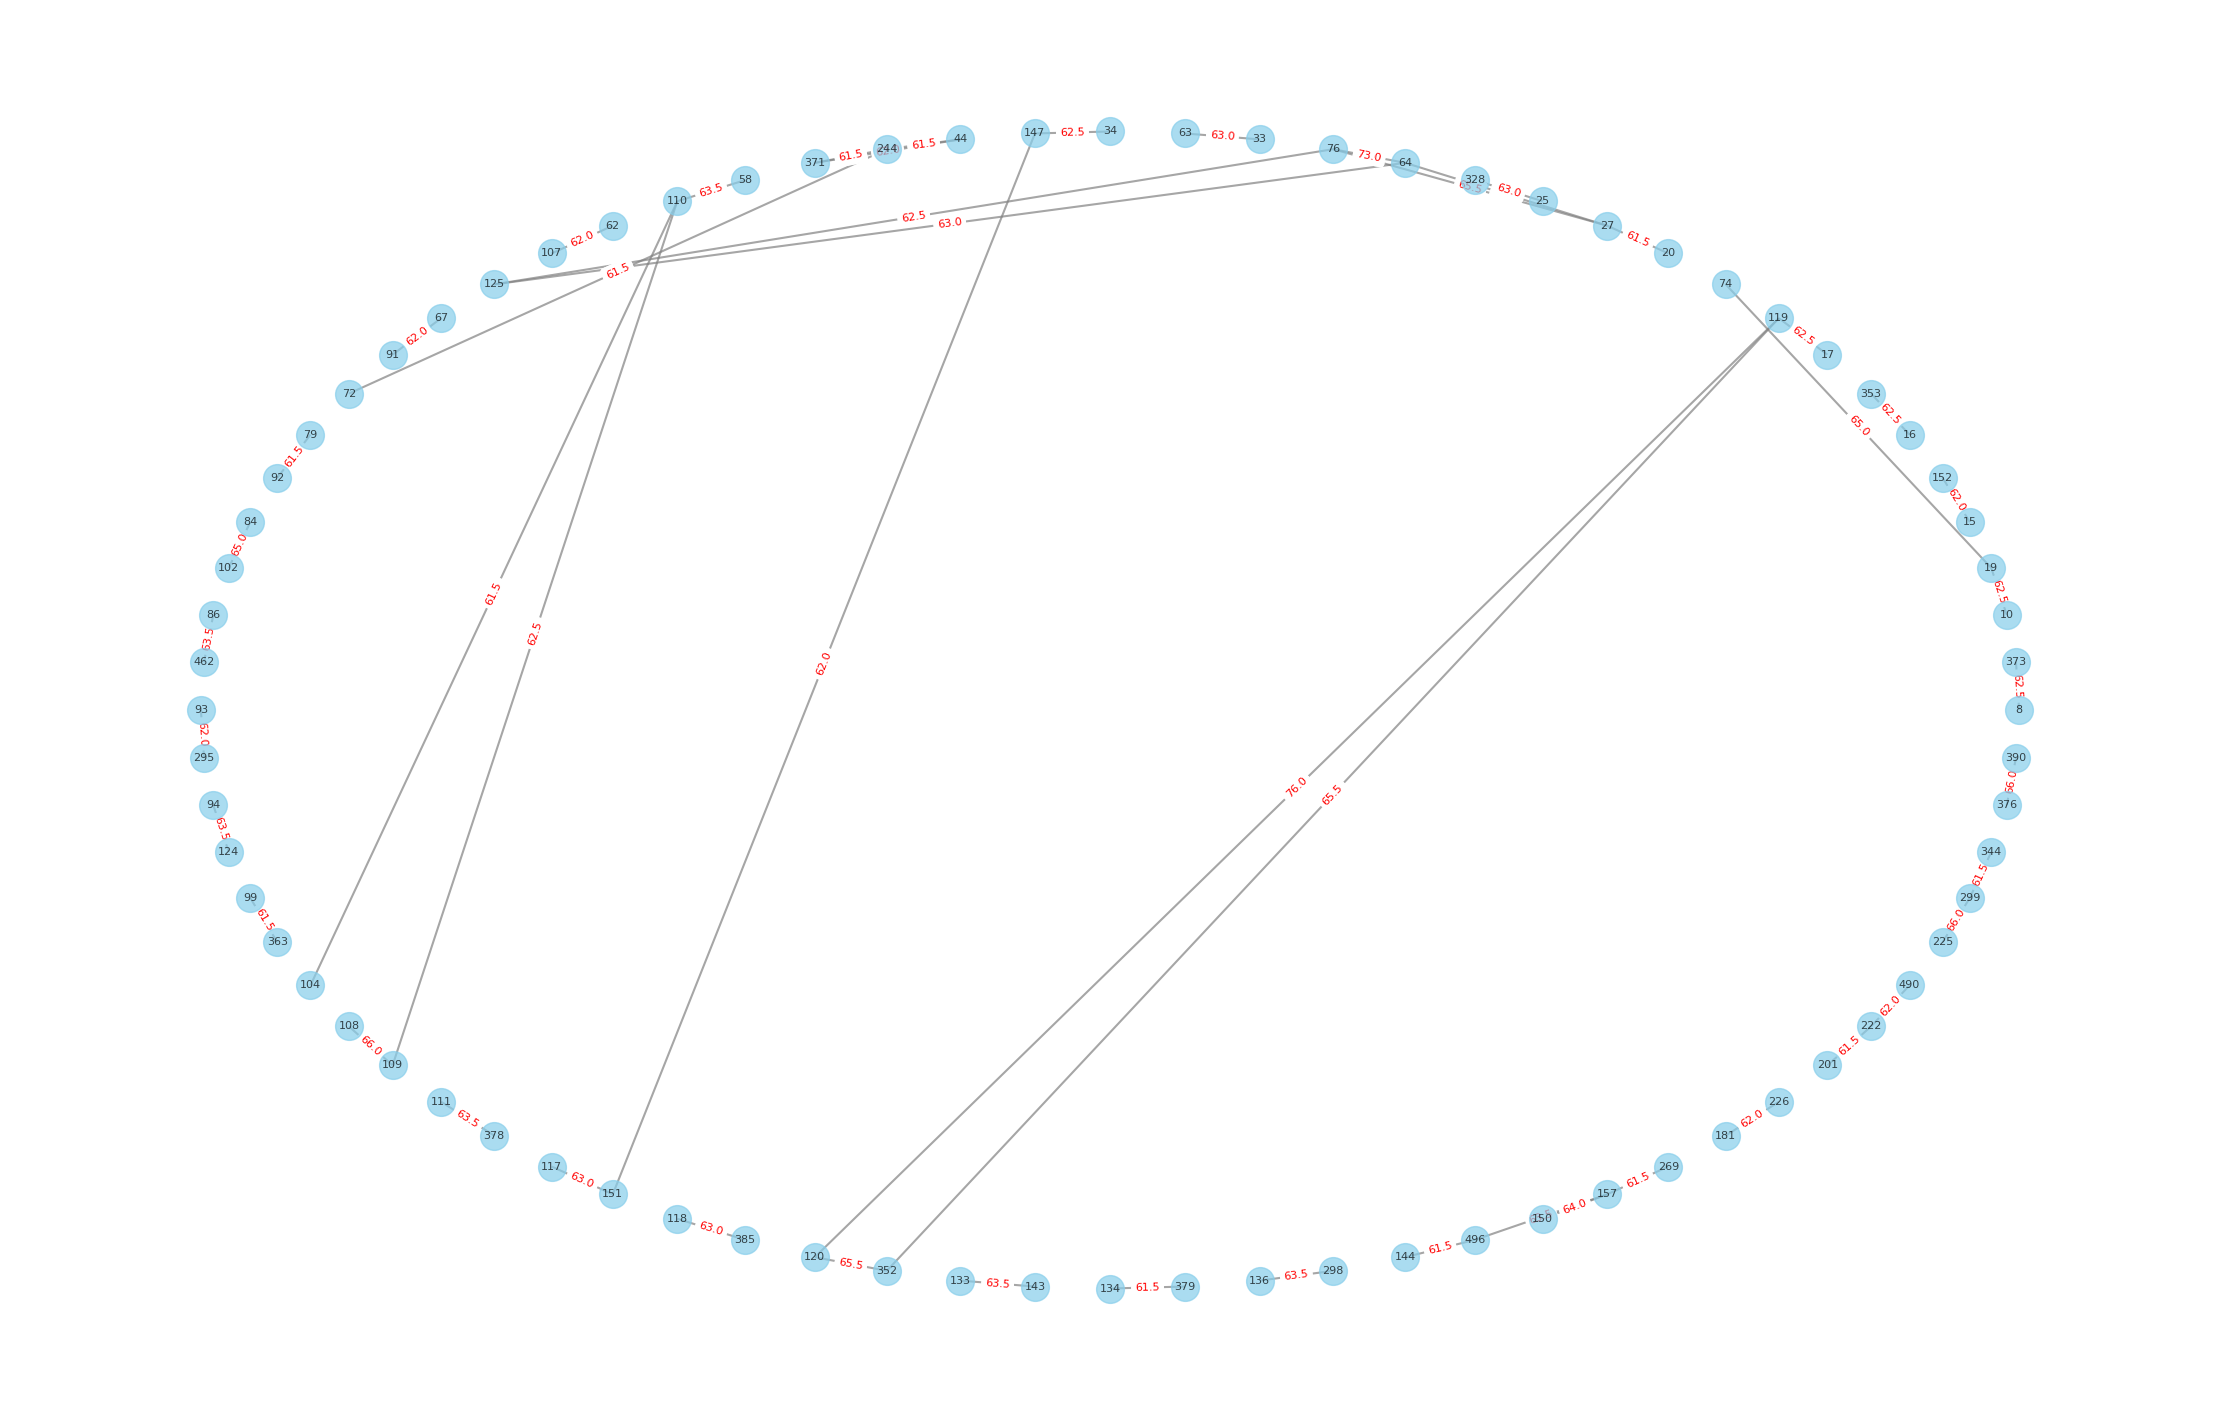

In [206]:
G = nx.from_pandas_edgelist(pairs_df,'a','b', ['weight'])
plt.figure(figsize=(22, 14))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=400, node_color='skyblue', edge_color='gray', width=1.5, alpha=0.7)
edge_labels = {(row['a'], row['b']): row['weight'] for idx, row in pairs_df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
plt.show()

Poniżej zobrazowano jeszcze bardziej znaczące pod względem podobieństwa receptory.

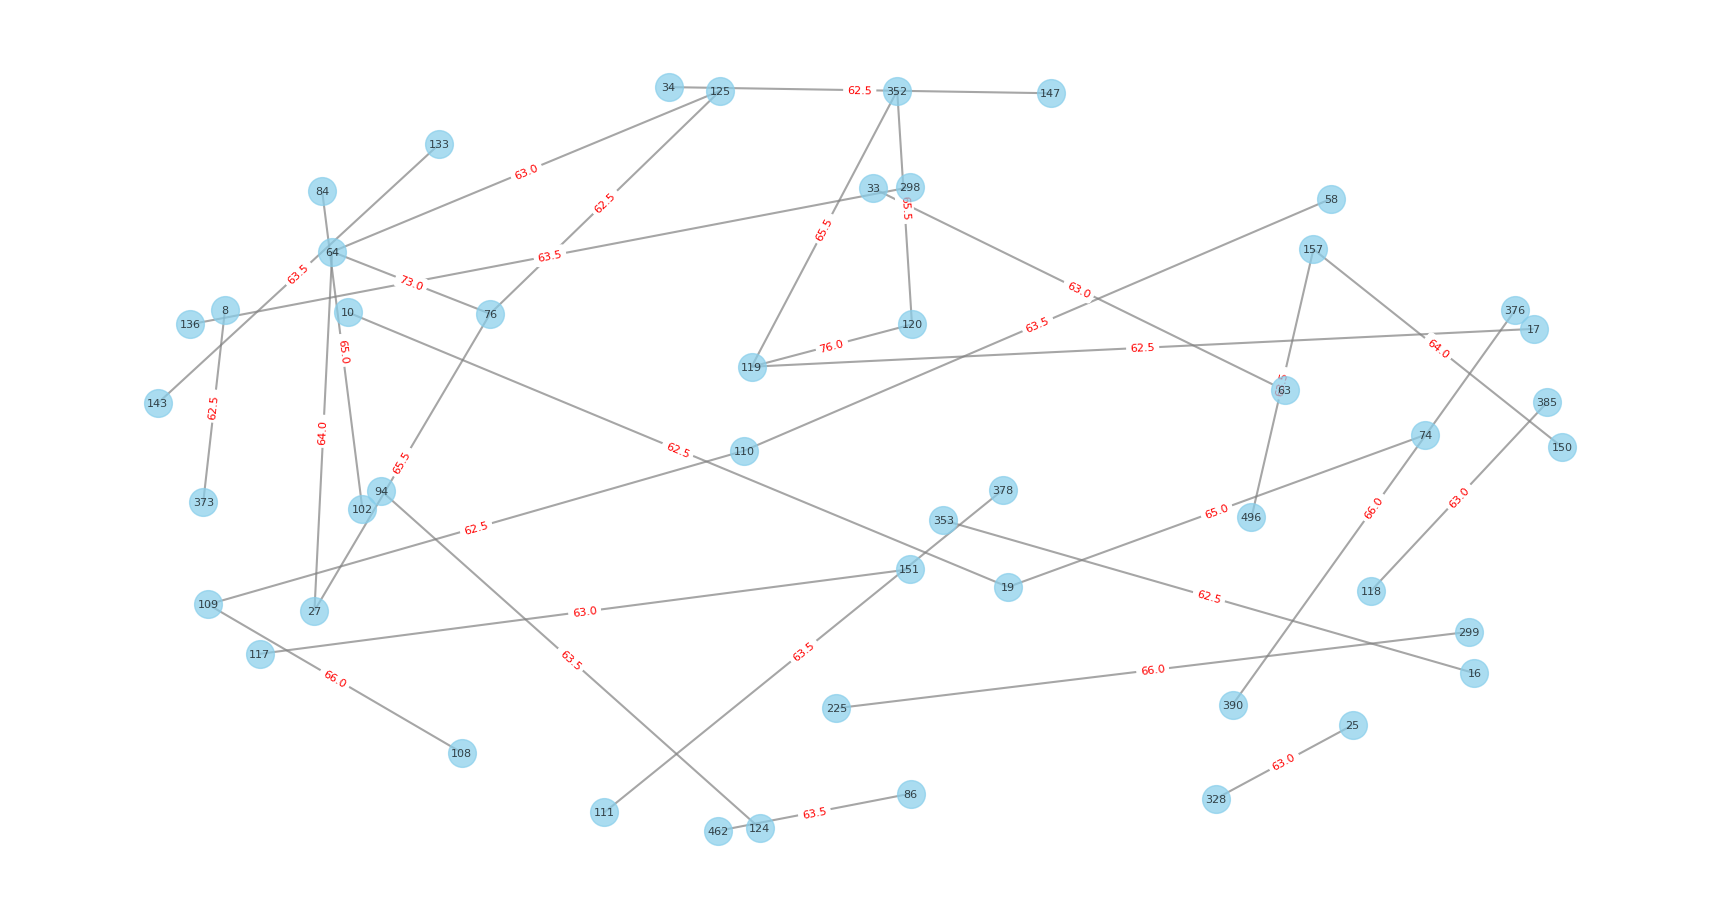

In [202]:
edges = np.where(distance_matrix_2>62)
pairs_df = pd.DataFrame(columns=['a', 'b', 'weight'])
for i in range(len(edges[0])):
    a = edges[0][i]
    b = edges[1][i]
    if a!=b:
        pairs_df.loc[i] = [a, b, distance_matrix_2[a, b]]
pairs_df[['a', 'b']] = pairs_df[['a', 'b']].astype(int)

G = nx.from_pandas_edgelist(pairs_df,'a','b', ['weight'])
plt.figure(figsize=(17, 9))
pos = nx.spring_layout(G, k=4, seed=12)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=400, node_color='skyblue', edge_color='gray', width=1.5, alpha=0.7)
edge_labels = {(row['a'], row['b']): row['weight'] for idx, row in pairs_df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
plt.show()

### 14. Stwórz graf podobieństwa dla reperuatu w oparciu o macierz dystansu wygenerowaną na podstawie wektorów numerycznych.

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Skorzystaj tej samej procedury co wyżej
</div>

In [207]:
edges = np.where(distance_matrix_3>26.5)
print(len(edges[0]))
pairs_df = pd.DataFrame(columns=['a', 'b', 'weight'])
for i in range(len(edges[0])):
    a = edges[0][i]
    b = edges[1][i]
    if a!=b:
        pairs_df.loc[i] = [a, b, distance_matrix_3[a, b]]
pairs_df[['a', 'b']] = pairs_df[['a', 'b']].astype(int)
pairs_df

104


,a,b,weight
0,0,484,27.881506
1,2,83,27.470172
2,2,162,26.603708
3,2,173,28.714727
4,2,210,27.506916
...,...,...,...
99,484,108,28.022936
100,484,109,28.770281
101,484,110,28.955279
102,484,177,26.542932


Powyżej wyodrębniono również około 100 najbardziej podobnych TCR (jak w poprzednim podejściu) i poniżej zwizualizowano w formie grafu.

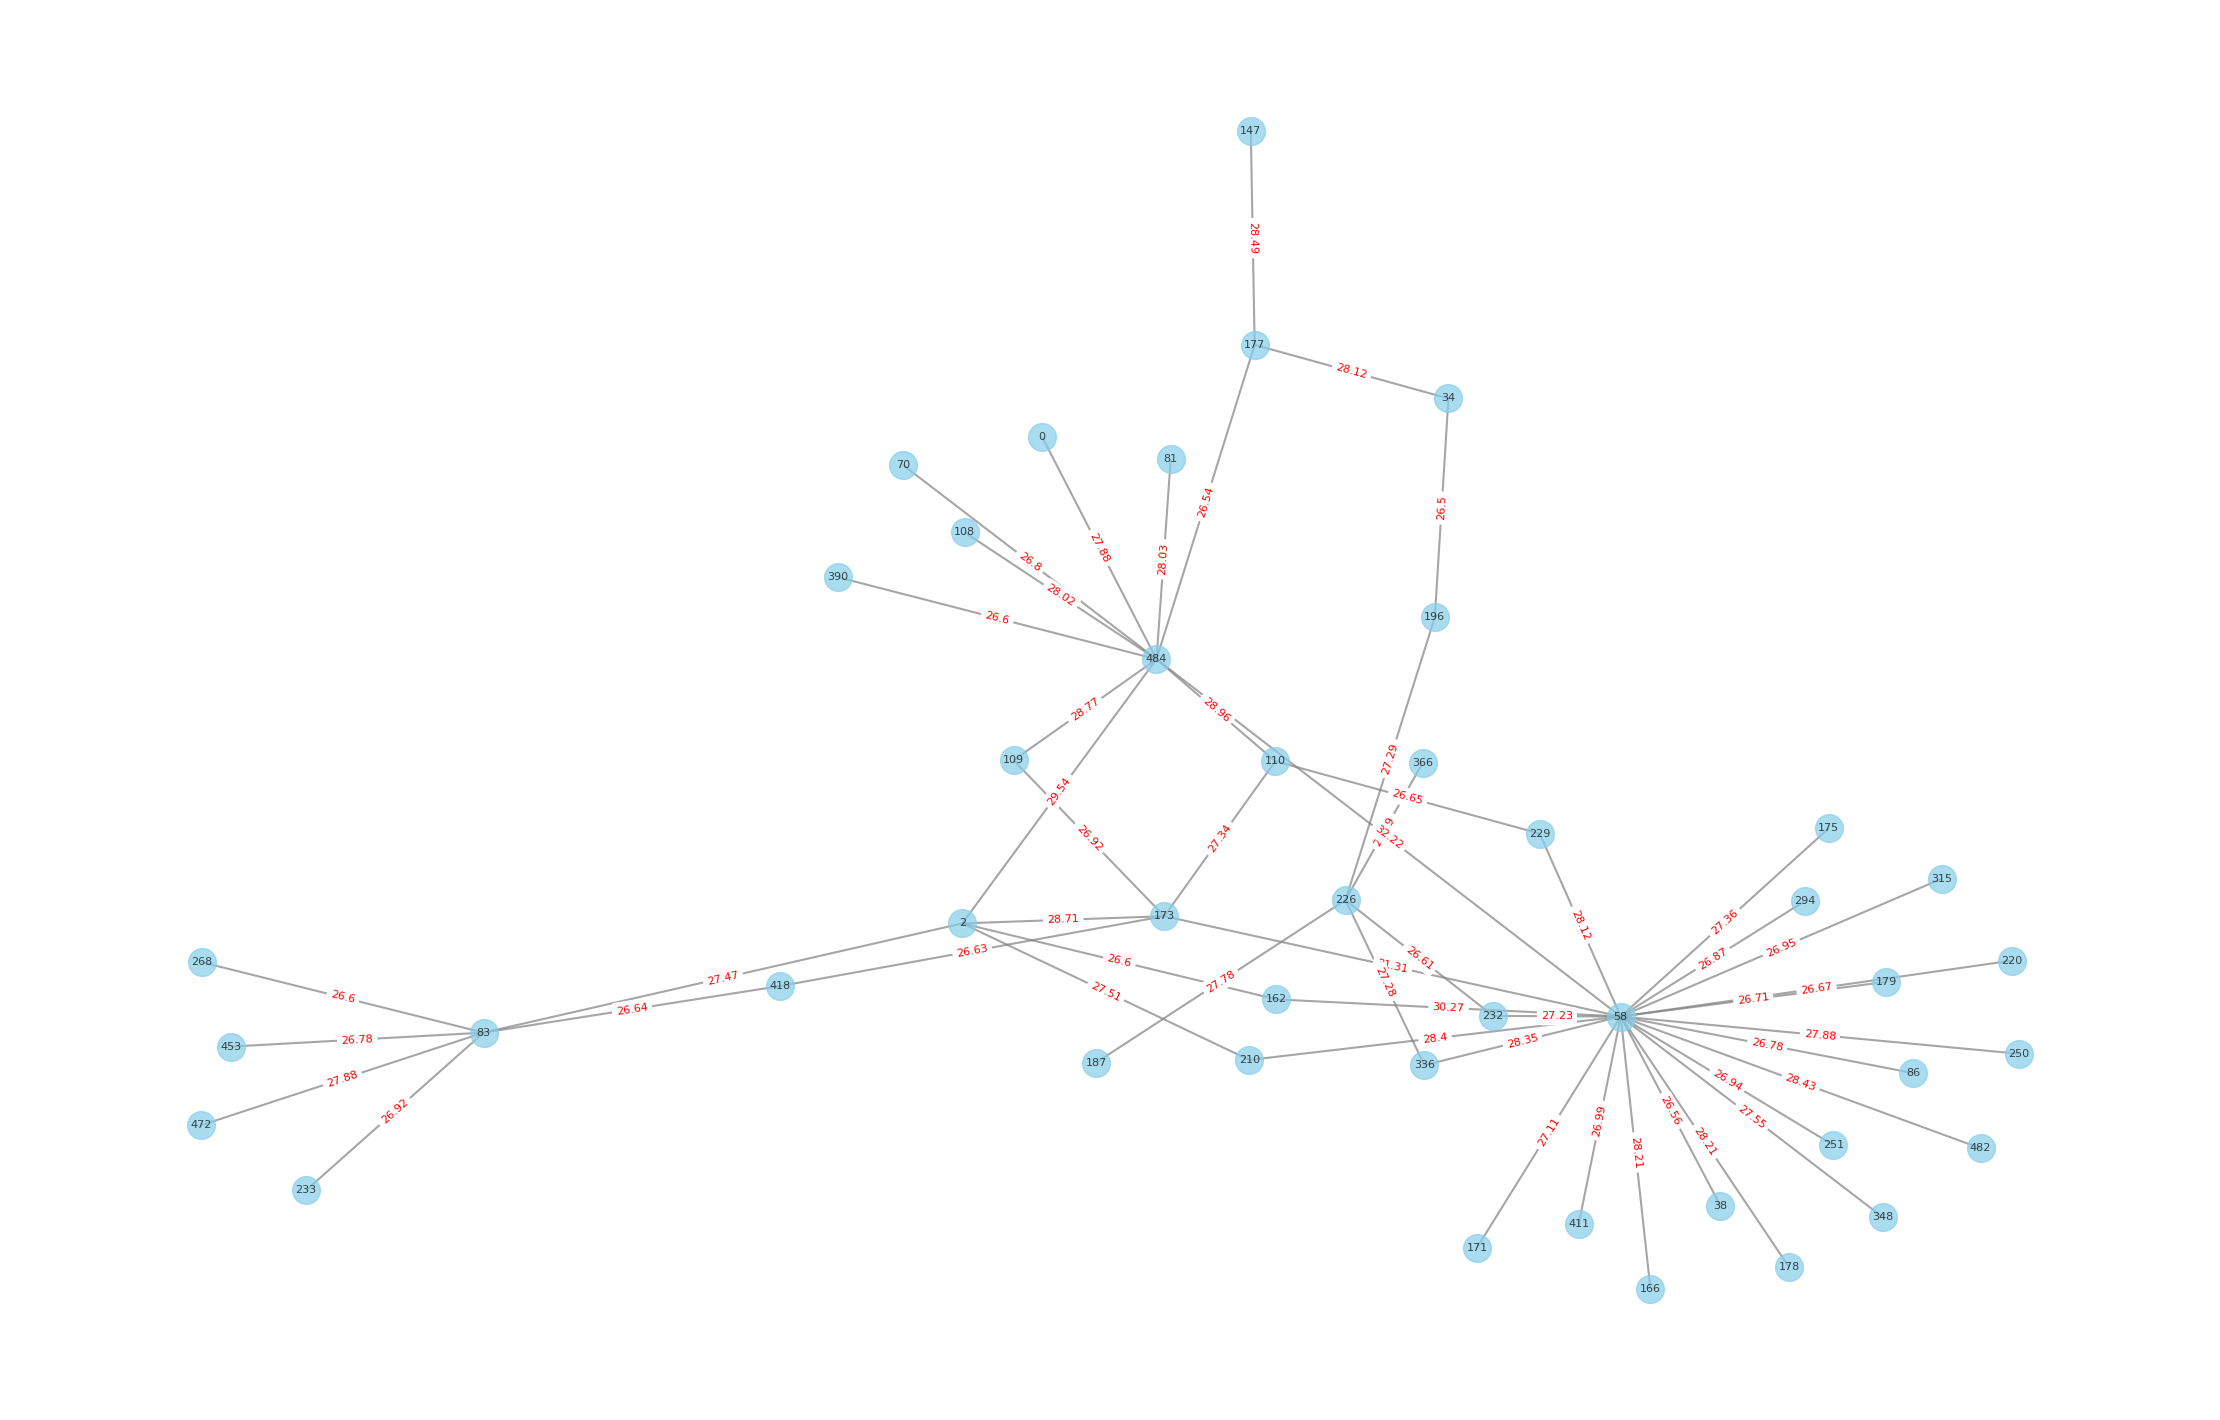

In [208]:
G2 = nx.from_pandas_edgelist(pairs_df,'a','b', ['weight'])
plt.figure(figsize=(22, 14))
pos = nx.spring_layout(G2)
nx.draw(G2, pos, with_labels=True, font_size=8, node_size=400, node_color='skyblue', edge_color='gray', width=1.5, alpha=0.7)
edge_labels = {(row['a'], row['b']): round(row['weight'],2) for idx, row in pairs_df.iterrows()}
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, font_color='red', font_size=8)
plt.show()

### 15. Opisz i porównaj grafy 

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Przeanalizuj perkolacje w grafie. Jak zmienia się rozkład wielkości składowych sieci wraz ze zmianą progu dla tworzenia połączeń między węzłami? Jak zmienia się średnia konektywność węzłów? Jaki próg podobieństwa receptorów jest najlepszy dla tworzenia połączeń w grafie? Który z grafów jest Twoim zdaniem lepszy do analizy?
</div>


Powyżej zwizualizowano oba grafy z optymalnymi progami podobieństwa, dla których można wyciągnąć jakiekolwiek wnioski z tej wizualizacji. Dla wyższych progów graf robi się już zbyt gęsty i nieczytelny. Widać zasadniczą różnicę między nimi taką, że graf wygenerowany na podstawie pierwszej, klasycznej macierzy podobieństwa tworzy wiele wierzchołków, których więszkość połączona jest tylko jedną krawędzią, w dodatku jest to graf składający się z wielu podgrafów. Natomiast graf zbudowany w oparciu o macierz podobieństwa receptorów w reprezentacji wektorowej jest grafem spójnym, to jest nie posiada izolowanych podgrafów, oraz posiada 2 centra - 'huby' gęsto połączone z pozostałymi wierzchołkami. 
Dlatego graf drugi jest w mojej opinii lepszy do analizy zarówno pod kątem logicznym, jak i wizualnym.  

Poniżej porównano ilość wierzchołków, konektywność i inne statystyki w zależności od różnych progów podobieństwa dla tych dwóch rodzjaów grafów:

Graf skonstruowany na podstawie klasycznej macierzy podobieństwa:

Graf o progu podobieństwa 45: 
Liczba krawędzi: 36714
Konektywność: 1
Srednia dlugosc najkrotszej sciezki: 1.9417959369117934 
Srednia ekscentryczosc: 3.4527162977867203
Pośrednictwo: 0.5206109931342481
Srednica: 4
Promien: 3



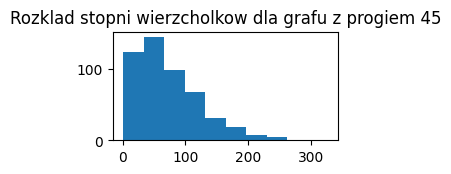

Graf o progu podobieństwa 50: 
Liczba krawędzi: 7944
Konektywność: 1
Srednia dlugosc najkrotszej sciezki: 2.7841397849462366 
Srednia ekscentryczosc: 4.769892473118279
Pośrednictwo: 0.3673502956575197
Srednica: 6
Promien: 4



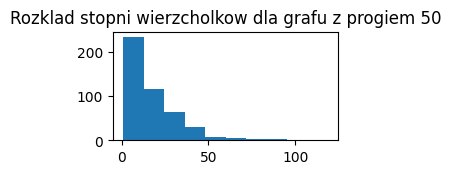

Graf o progu podobieństwa 55: 
Liczba krawędzi: 1300
Konektywność: 0
Graf niespójny


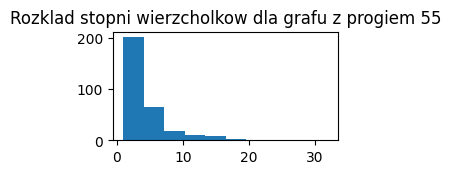

Graf o progu podobieństwa 60: 
Liczba krawędzi: 176
Konektywność: 0
Graf niespójny


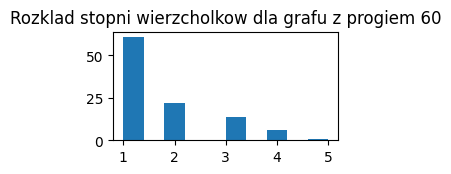

Graf o progu podobieństwa 65: 
Liczba krawędzi: 16
Konektywność: 0
Graf niespójny


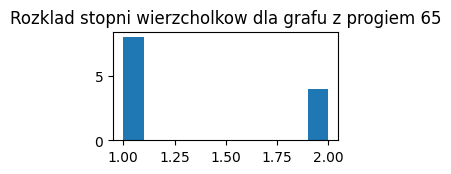

In [255]:
from statistics import mean
for i in range(45, 66, 5):
    j=1
    edges = np.where(distance_matrix_2>i)
    pairs_df = pd.DataFrame(columns=['a', 'b', 'weight'])
    for m in range(len(edges[0])):
        a, b = edges[0][m], edges[1][m]
        if a!=b:
            pairs_df.loc[m] = [a, b, distance_matrix_2[a, b]]
    pairs_df[['a', 'b']] = pairs_df[['a', 'b']].astype(int)
    G = nx.from_pandas_edgelist(pairs_df,'a','b', ['weight'])
    print(f'Graf o progu podobieństwa {i}: \nLiczba krawędzi: {pairs_df.shape[0]}\nKonektywność: {nx.node_connectivity(G)}')
    try:
        eccentricity = nx.eccentricity(G).values()
        closeness = nx.closeness_centrality(G).values()
        print(f'Srednia dlugosc najkrotszej sciezki: {nx.average_shortest_path_length(G)} \nSrednia ekscentryczosc: {mean(eccentricity)}\nPośrednictwo: {mean(closeness)}\nSrednica: {max(eccentricity)}\nPromien: {min(eccentricity)}\n')
    except:
        print('Graf niespójny')
    degrees = [val for (node, val) in G.degree()]
    plt.subplot(3,2,j)
    plt.hist(degrees)
    plt.title(f'Rozklad stopni wierzcholkow dla grafu z progiem {i}')
    plt.show()
    j+=1


Graf skonstruowany na podstawie macierzy podobieństwa z reprezentacji wektorowej:

Graf o progu podobieństwa 16.5: 
Liczba krawędzi: 36518
Konektywność: 4
Srednia dlugosc najkrotszej sciezki: 1.855054108216433 
Srednia ekscentryczosc: 2.154
Pośrednictwo: 0.5430462833298766
Srednica: 3
Promien: 2



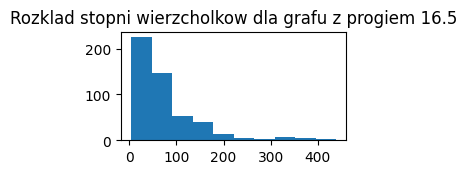

Graf o progu podobieństwa 19.5: 
Liczba krawędzi: 10318
Konektywność: 1
Srednia dlugosc najkrotszej sciezki: 2.1207253427686865 
Srednia ekscentryczosc: 3.060924369747899
Pośrednictwo: 0.4751817880235482
Srednica: 4
Promien: 2



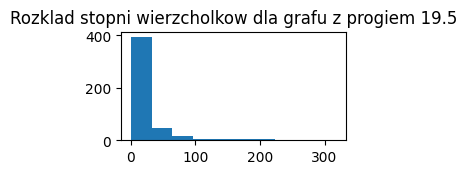

Graf o progu podobieństwa 22.5: 
Liczba krawędzi: 2048
Konektywność: 1
Srednia dlugosc najkrotszej sciezki: 2.491590403165966 
Srednia ekscentryczosc: 3.7564102564102564
Pośrednictwo: 0.40533457536282674
Srednica: 4
Promien: 3



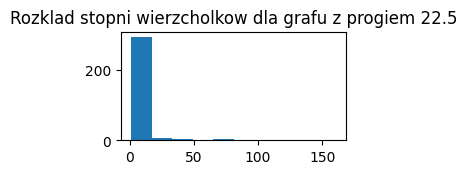

Graf o progu podobieństwa 25.5: 
Liczba krawędzi: 252
Konektywność: 1
Srednia dlugosc najkrotszej sciezki: 2.9101903695408735 
Srednia ekscentryczosc: 4.2631578947368425
Pośrednictwo: 0.35102952313920377
Srednica: 5
Promien: 3



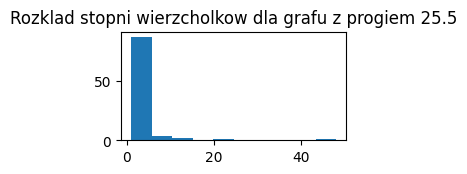

Graf o progu podobieństwa 28.5: 
Liczba krawędzi: 14
Konektywność: 1
Srednia dlugosc najkrotszej sciezki: 1.9047619047619047 
Srednia ekscentryczosc: 2.7142857142857144
Pośrednictwo: 0.544824223395652
Srednica: 3
Promien: 2



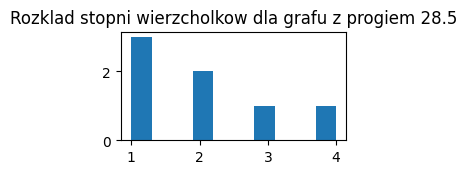

In [263]:
for i in np.arange(16.5, 29.0, 3.0):
    j=1
    edges = np.where(distance_matrix_3>i)
    pairs_df = pd.DataFrame(columns=['a', 'b', 'weight'])
    for m in range(len(edges[0])):
        a, b = edges[0][m], edges[1][m]
        if a!=b:
            pairs_df.loc[m] = [a, b, distance_matrix_3[a, b]]
    pairs_df[['a', 'b']] = pairs_df[['a', 'b']].astype(int)
    G = nx.from_pandas_edgelist(pairs_df,'a','b', ['weight'])
    print(f'Graf o progu podobieństwa {i}: \nLiczba krawędzi: {pairs_df.shape[0]}\nKonektywność: {nx.node_connectivity(G)}')
    try:
        eccentricity = nx.eccentricity(G).values()
        closeness = nx.closeness_centrality(G).values()
        print(f'Srednia dlugosc najkrotszej sciezki: {nx.average_shortest_path_length(G)} \nSrednia ekscentryczosc: {mean(eccentricity)}\nPośrednictwo: {mean(closeness)}\nSrednica: {max(eccentricity)}\nPromien: {min(eccentricity)}\n')
    except:
        print('Graf niespójny')
    degrees = [val for (node, val) in G.degree()]
    plt.subplot(3,2,j)
    plt.hist(degrees)
    plt.title(f'Rozklad stopni wierzcholkow dla grafu z progiem {i}')
    plt.show()
    j+=1


Widać, że liczba krawędzi jest porównywalna w obu grafach, ale rozkład stopni wierzchołków jest inny. W grafie 2 stopnie te są większe, co oznacza, że jest on na ogół bardziej połączony. Widać również, że graf 2 za każdym razem jest spójny, a w grafie 1 przy wyższych progach podobieństwa mamy już grafy niespójne, składające się z wielu podgrafów. Konektywność, czyli liczba krawędzi jakie należy usunąć aby graf był niespójny, również jest większa w drugim rodzaju grafu. Pozostałe statystyki jak eskcentryczność czy pośrednictwo (tam gdzie da się porównać) również wypadają na korzyść drugiego rodzaju grafu. Dlatego ogólnie można przyjąć, że grafy konstruowane na podstawie wektorowej reprezentacji receptorów są lepsze jakościowo. Graf 2 charakteryzuje się zdecydowanie lepszym przepływem danych i perkolacją. 

<div class="alert alert-block alert-info">
<b>Dla zainteresowanych:</b> Porównaj miary z wygenerowanym losowo grafem. Jaki algorytm generowania grafów będzie najlepszy do tego?
</div>


Parameter p: 0.3, Muber of vertices: 20, Number of egdes: 37370, Density: 0.29955911823647297
Srednia dlugosc najkrotszej sciezki: 1.700440881763527 
Srednia ekscentryczosc: 2
Pośrednictwo: 0.5881656799515093
Srednica: 2
Promien: 2



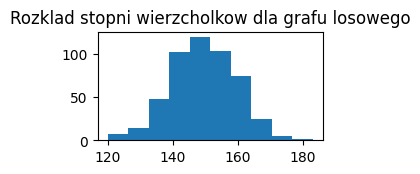

In [270]:
G = nx.erdos_renyi_graph(500, 0.3)
print(f'Parameter p: 0.3, Muber of vertices: 20, Number of egdes: {nx.number_of_edges(G)}, Density: {nx.density(G)}')
try:
    eccentricity = nx.eccentricity(G).values()
    closeness = nx.closeness_centrality(G).values()
    print(f'Srednia dlugosc najkrotszej sciezki: {nx.average_shortest_path_length(G)} \nSrednia ekscentryczosc: {mean(eccentricity)}\nPośrednictwo: {mean(closeness)}\nSrednica: {max(eccentricity)}\nPromien: {min(eccentricity)}\n')
except:
    print('Graf niespójny')
degrees = [val for (node, val) in G.degree()]
plt.subplot(3,2,1)
plt.hist(degrees)
plt.title(f'Rozklad stopni wierzcholkow dla grafu losowego')
plt.show()

Stworozono losyw graf o podobnej liczbie krawędzi do 1 grafu drugiego typu (ok. 37 tysięcy). Widać zdecydowane podobieństwo w parametrach, jednak znaczącno różni się tutaj rozkład wierzchołków. W grafie receptorów mieliśmy kilka dużych hubów i wiele wierzchołków o mniejszym stopniu, tutaj natomiast stworzył nam się graf losowy, którego rozkład stopni wierzchołków jest normalny i mamy wiele wiezrchołków średnio połaczonych (ale i tak gęsto w porównaniu do grafu receptorów) i brakuje tu bardzo mocno połączonych hubów.